In [117]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
from misc.golden_section_search import Search

In [118]:
"""
Michael Pham
July 2024

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

first iteration with only K as state variable
no consumption tax, no human capital investment structure
"""

'\nMichael Pham\nJuly 2024\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nfirst iteration with only K as state variable\nno consumption tax, no human capital investment structure\n'

In [119]:
exp = np.e
log = math.log

In [120]:
# Parameters - households and firms
beta = 0.95  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 0.5  # disutility from working
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
# phi_p = 0.5  # share of parental input in education
# psi_e = 0.5  # CES parameter for education inputs
# theta_I = 0.7  # human capital investment effectiveness
tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
# Ie_gdp = 0.02 # public education investment as percent of GDP
# Iz_gdp = 0.04 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.2  # public investment inefficiency
G_gdp = 0.1      # grants (as a fraction of GDP)
# psi = 0.1    # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 200  # number of points in capital grid
# nH = 20   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# Hmin = 0
# Hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 10
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10        # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K

# Number of periods
periods = 40
child_periods = 18

In [121]:
h_init = 1
l_init = 0.2
r_init = beta**(-1) - 1

In [122]:
def production(K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * K_prev**alpha * (H*L)**(1-alpha)

def wage_rate(K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return H * tfp * (1-alpha) * (K_prev)**alpha * (H*L)**(-alpha)

def interest_rate(K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * alpha * (H*L)**(1-alpha) * K_prev**(alpha-1) - delta

In [123]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  T = tax_revenue + G
  return T

In [124]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


def next_value_function(k):
  return vr_polate(k)


def value_function(k, k_prev, l, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  c = (1-tau)*w*h*l + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  return utility(c, l) + beta * next_value_function(k)

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + r*k_prev - tau*r*max(k_prev, 0) + T - k


In [125]:
#initialize steady state variable predictions
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
K_bar = ((r_init + delta)/(alpha*tfp))**(1/(alpha-1)) * (H_bar * L_bar) #refers to guess of K in prev period
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100

h = 1
l = 0.2

K_bar

0.6321720398144471

iter: 0; K change: 158.18; H change: 100.00; L change: 10.00
iter: 0; K: 0.63; H: 1.00; L: 0.20
iter: 0; Y: 0.29; tau: 0.15; T: 0.06
iter: 0, i: 40, k: 0.6321720398144471
iter: 0, i: 39, k: 0.6321720398144471
iter: 0, i: 38, k: 0.6321720398144471
iter: 0, i: 37, k: 0.6321720398144471
iter: 0, i: 36, k: 0.6321720398144471
iter: 0, i: 35, k: 0.6321720398144471
iter: 0, i: 34, k: 0.6321720398144471
iter: 0, i: 33, k: 0.6321720398144471
iter: 0, i: 32, k: 0.6321720398144471
iter: 0, i: 31, k: 0.6321720398144471
iter: 0, i: 30, k: 0.6321720398144471
iter: 0, i: 29, k: 0.6321720398144471
iter: 0, i: 28, k: 0.6321720398144471
iter: 0, i: 27, k: 0.6321720398144471
iter: 0, i: 26, k: 0.6321720398144471
iter: 0, i: 25, k: 0.6321720398144471
iter: 0, i: 24, k: 0.6321720398144471
iter: 0, i: 23, k: 0.6321720398144471
iter: 0, i: 22, k: 0.6321720398144471
iter: 0, i: 21, k: 0.6321720398144471
iter: 0, i: 20, k: 0.6321720398144471
iter: 0, i: 19, k: 0.6321720398144471
iter: 0, i: 18, k: 0.6321720398

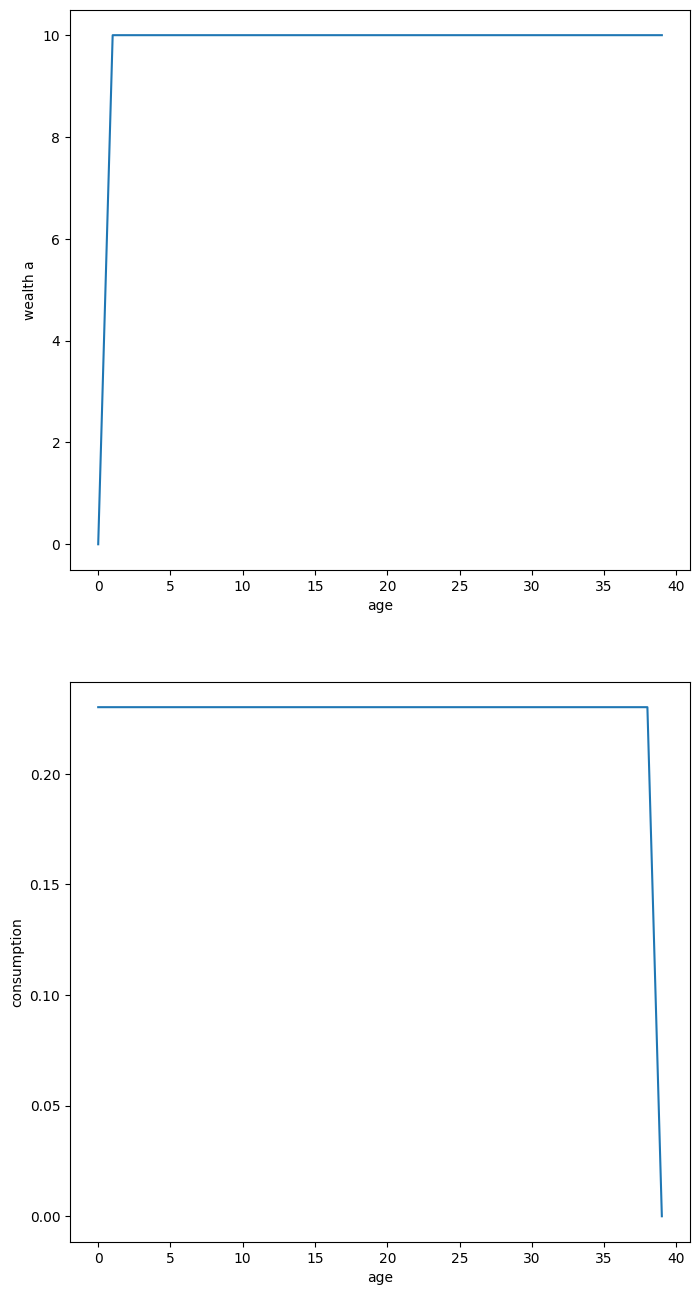

iter: 1; K change: 0.74; H change: 0.00; L change: 0.00
iter: 1; K: 2.46; H: 1.00; L: 0.20
iter: 1; Y: 0.46; tau: 0.15; T: 0.08
iter: 1, i: 40, k: 2.4557376318515574
iter: 1, i: 39, k: 2.4557376318515574
iter: 1, i: 38, k: 2.4557376318515574
iter: 1, i: 37, k: 2.4557376318515574
iter: 1, i: 36, k: 2.4557376318515574
iter: 1, i: 35, k: 2.4557376318515574
iter: 1, i: 34, k: 2.4557376318515574
iter: 1, i: 33, k: 2.4557376318515574
iter: 1, i: 32, k: 2.4557376318515574
iter: 1, i: 31, k: 2.4557376318515574
iter: 1, i: 30, k: 2.4557376318515574
iter: 1, i: 29, k: 2.4557376318515574
iter: 1, i: 28, k: 2.4557376318515574
iter: 1, i: 27, k: 2.4557376318515574
iter: 1, i: 26, k: 2.4557376318515574
iter: 1, i: 25, k: 2.4557376318515574
iter: 1, i: 24, k: 2.4557376318515574
iter: 1, i: 23, k: 2.4557376318515574
iter: 1, i: 22, k: 2.4557376318515574
iter: 1, i: 21, k: 2.4557376318515574
iter: 1, i: 20, k: 2.4557376318515574
iter: 1, i: 19, k: 2.4557376318515574
iter: 1, i: 18, k: 2.455737631851557

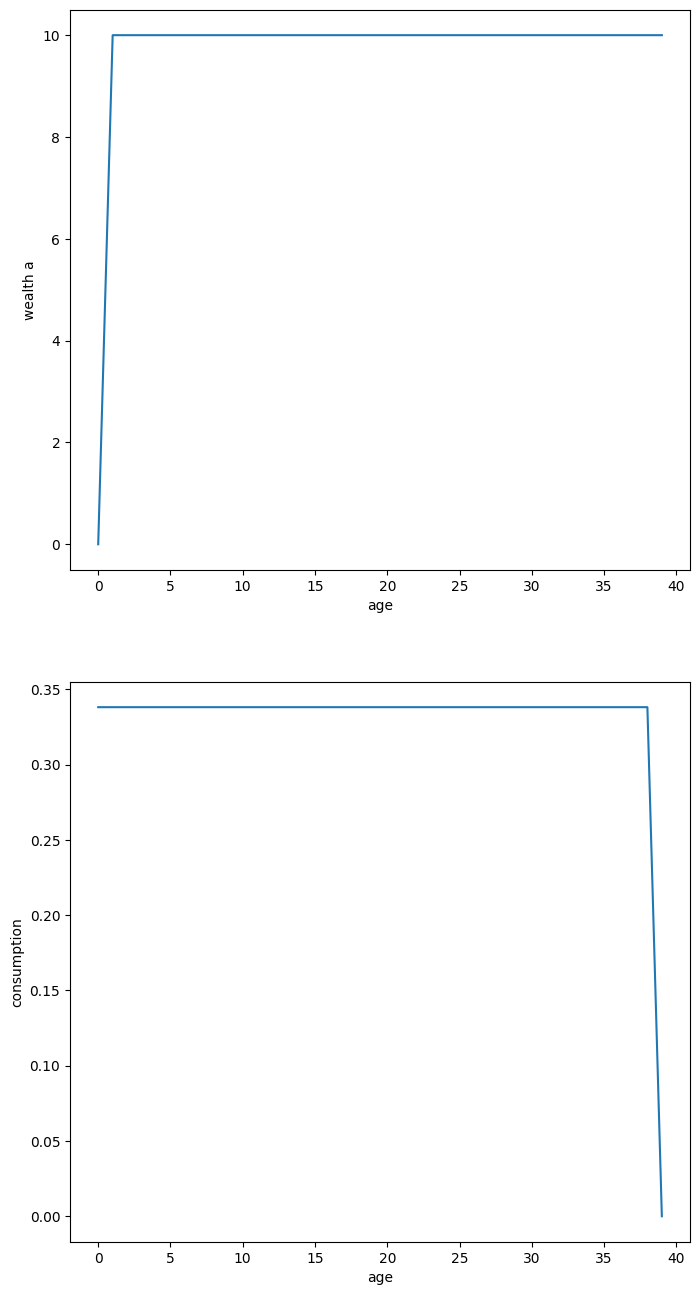

iter: 2; K change: 0.37; H change: 0.00; L change: 0.00
iter: 2; K: 3.91; H: 1.00; L: 0.20
iter: 2; Y: 0.53; tau: 0.15; T: 0.07
iter: 2, i: 40, k: 3.9145901054812455
iter: 2, i: 39, k: 3.9145901054812455
iter: 2, i: 38, k: 3.9145901054812455
iter: 2, i: 37, k: 3.9145901054812455
iter: 2, i: 36, k: 3.9145901054812455
iter: 2, i: 35, k: 3.9145901054812455
iter: 2, i: 34, k: 3.9145901054812455
iter: 2, i: 33, k: 3.9145901054812455
iter: 2, i: 32, k: 3.9145901054812455
iter: 2, i: 31, k: 3.9145901054812455
iter: 2, i: 30, k: 3.9145901054812455
iter: 2, i: 29, k: 3.9145901054812455
iter: 2, i: 28, k: 3.9145901054812455
iter: 2, i: 27, k: 3.9145901054812455
iter: 2, i: 26, k: 3.9145901054812455
iter: 2, i: 25, k: 3.9145901054812455
iter: 2, i: 24, k: 3.9145901054812455
iter: 2, i: 23, k: 3.9145901054812455
iter: 2, i: 22, k: 3.9145901054812455
iter: 2, i: 21, k: 3.9145901054812455
iter: 2, i: 20, k: 3.9145901054812455
iter: 2, i: 19, k: 3.9145901054812455
iter: 2, i: 18, k: 3.914590105481245

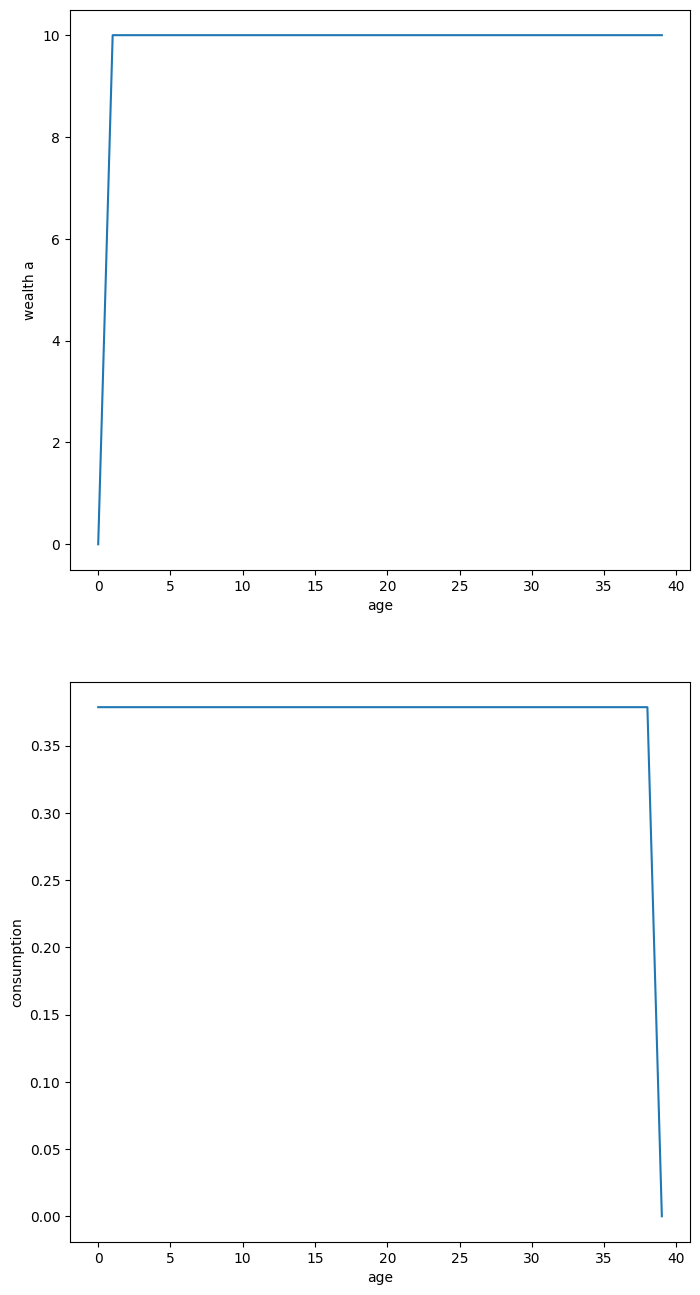

iter: 3; K change: 0.23; H change: 0.00; L change: 0.00
iter: 3; K: 5.08; H: 1.00; L: 0.20
iter: 3; Y: 0.58; tau: 0.15; T: 0.07
iter: 3, i: 40, k: 5.081672084384996
iter: 3, i: 39, k: 5.081672084384996
iter: 3, i: 38, k: 5.081672084384996
iter: 3, i: 37, k: 5.081672084384996
iter: 3, i: 36, k: 5.081672084384996
iter: 3, i: 35, k: 5.081672084384996
iter: 3, i: 34, k: 5.081672084384996
iter: 3, i: 33, k: 5.081672084384996
iter: 3, i: 32, k: 5.081672084384996
iter: 3, i: 31, k: 5.081672084384996
iter: 3, i: 30, k: 5.081672084384996
iter: 3, i: 29, k: 5.081672084384996
iter: 3, i: 28, k: 5.081672084384996
iter: 3, i: 27, k: 5.081672084384996
iter: 3, i: 26, k: 5.081672084384996
iter: 3, i: 25, k: 5.081672084384996
iter: 3, i: 24, k: 5.081672084384996
iter: 3, i: 23, k: 5.081672084384996
iter: 3, i: 22, k: 5.081672084384996
iter: 3, i: 21, k: 5.081672084384996
iter: 3, i: 20, k: 5.081672084384996
iter: 3, i: 19, k: 5.081672084384996
iter: 3, i: 18, k: 5.081672084384996
iter: 3, i: 17, k: 5.

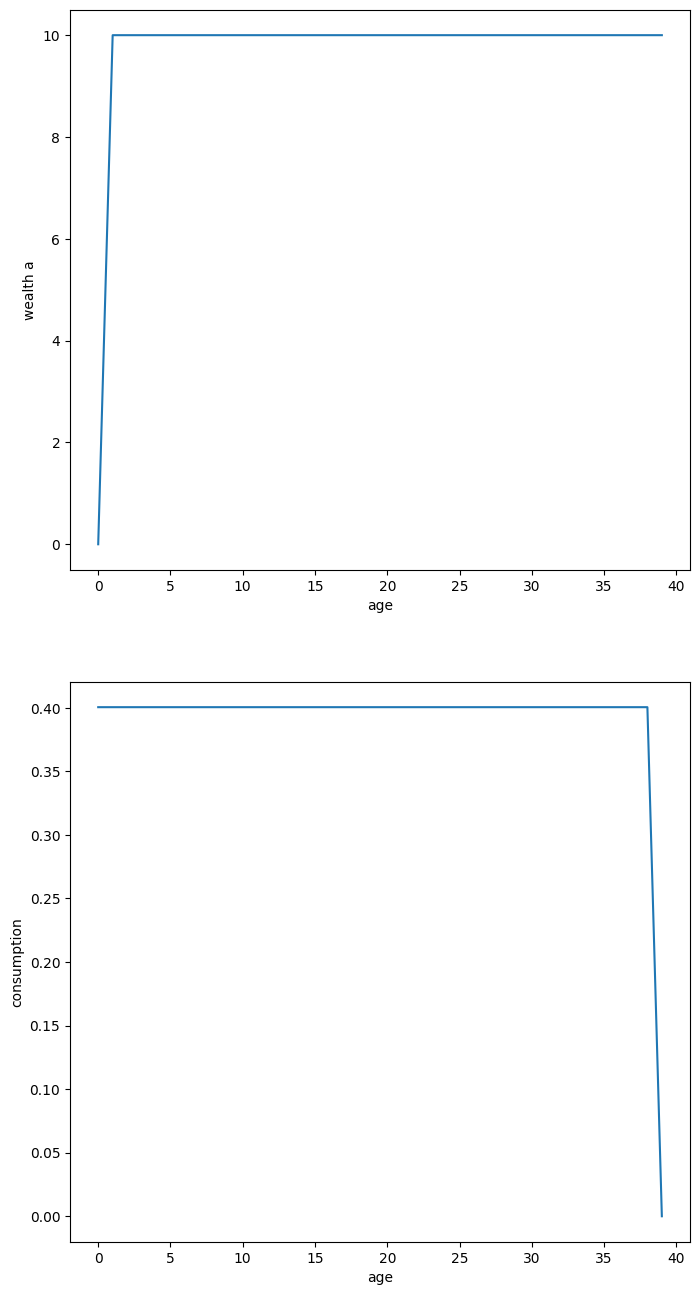

iter: 4; K change: 0.16; H change: 0.00; L change: 0.00
iter: 4; K: 6.02; H: 1.00; L: 0.20
iter: 4; Y: 0.61; tau: 0.15; T: 0.06
iter: 4, i: 40, k: 6.015337667507996
iter: 4, i: 39, k: 6.015337667507996
iter: 4, i: 38, k: 6.015337667507996
iter: 4, i: 37, k: 6.015337667507996
iter: 4, i: 36, k: 6.015337667507996
iter: 4, i: 35, k: 6.015337667507996
iter: 4, i: 34, k: 6.015337667507996
iter: 4, i: 33, k: 6.015337667507996
iter: 4, i: 32, k: 6.015337667507996
iter: 4, i: 31, k: 6.015337667507996
iter: 4, i: 30, k: 6.015337667507996
iter: 4, i: 29, k: 6.015337667507996
iter: 4, i: 28, k: 6.015337667507996
iter: 4, i: 27, k: 6.015337667507996
iter: 4, i: 26, k: 6.015337667507996
iter: 4, i: 25, k: 6.015337667507996
iter: 4, i: 24, k: 6.015337667507996
iter: 4, i: 23, k: 6.015337667507996
iter: 4, i: 22, k: 6.015337667507996
iter: 4, i: 21, k: 6.015337667507996
iter: 4, i: 20, k: 6.015337667507996
iter: 4, i: 19, k: 6.015337667507996
iter: 4, i: 18, k: 6.015337667507996
iter: 4, i: 17, k: 6.

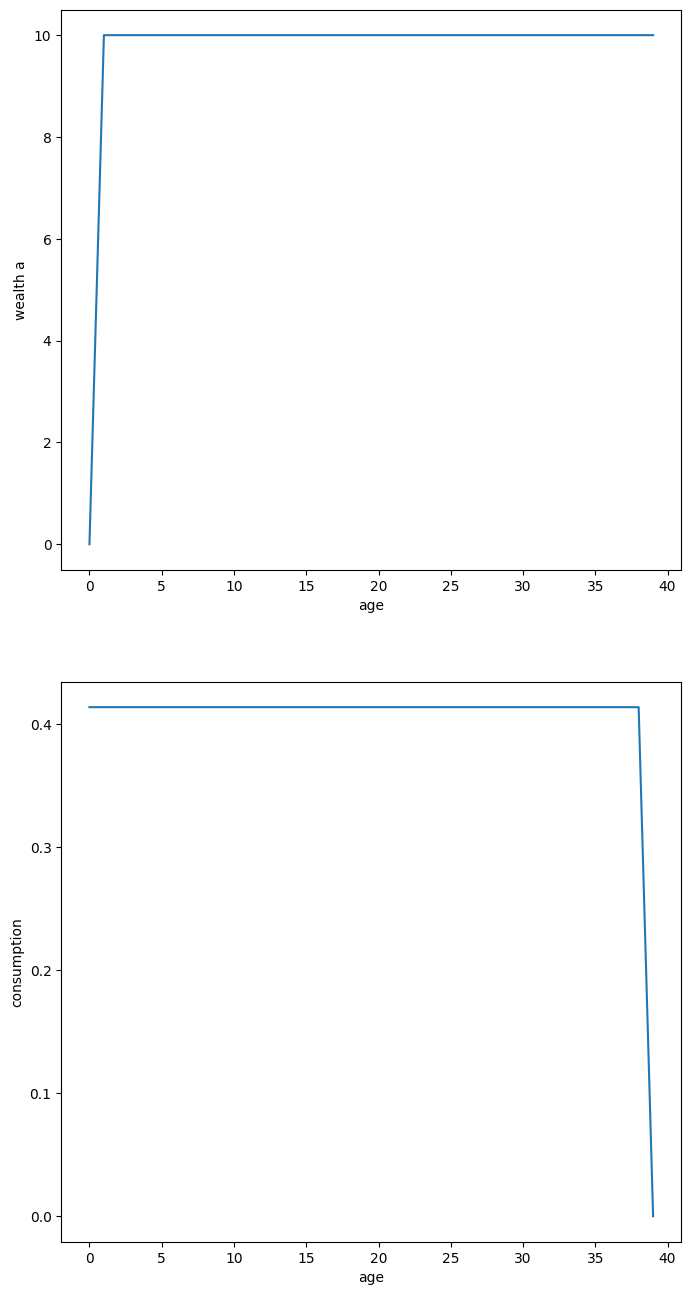

iter: 5; K change: 0.11; H change: 0.00; L change: 0.00
iter: 5; K: 6.76; H: 1.00; L: 0.20
iter: 5; Y: 0.64; tau: 0.15; T: 0.06
iter: 5, i: 40, k: 6.762270134006396
iter: 5, i: 39, k: 6.762270134006396
iter: 5, i: 38, k: 6.762270134006396
iter: 5, i: 37, k: 6.762270134006396
iter: 5, i: 36, k: 6.762270134006396
iter: 5, i: 35, k: 6.762270134006396
iter: 5, i: 34, k: 6.762270134006396
iter: 5, i: 33, k: 6.762270134006396
iter: 5, i: 32, k: 6.762270134006396
iter: 5, i: 31, k: 6.762270134006396
iter: 5, i: 30, k: 6.762270134006396
iter: 5, i: 29, k: 6.762270134006396
iter: 5, i: 28, k: 6.762270134006396
iter: 5, i: 27, k: 6.762270134006396
iter: 5, i: 26, k: 6.762270134006396
iter: 5, i: 25, k: 6.762270134006396
iter: 5, i: 24, k: 6.762270134006396
iter: 5, i: 23, k: 6.762270134006396
iter: 5, i: 22, k: 6.762270134006396
iter: 5, i: 21, k: 6.762270134006396
iter: 5, i: 20, k: 6.762270134006396
iter: 5, i: 19, k: 6.762270134006396
iter: 5, i: 18, k: 6.762270134006396
iter: 5, i: 17, k: 6.

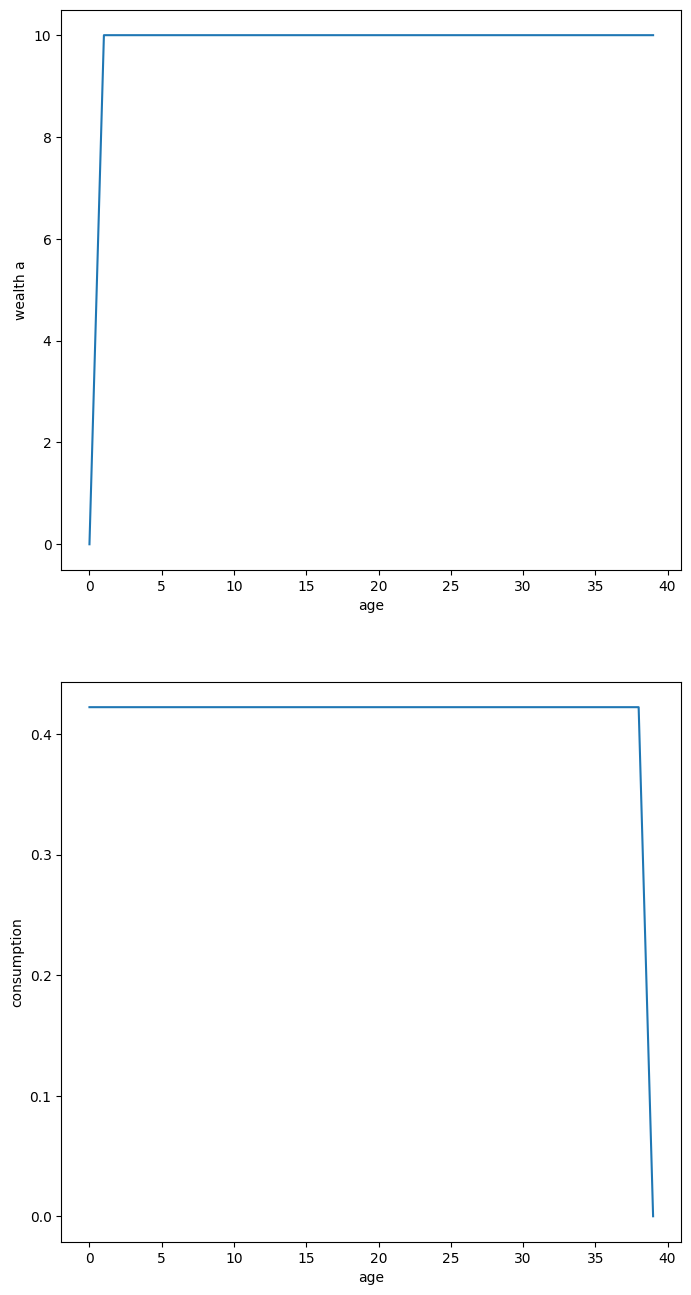

iter: 6; K change: 0.08; H change: 0.00; L change: 0.00
iter: 6; K: 7.36; H: 1.00; L: 0.20
iter: 6; Y: 0.66; tau: 0.15; T: 0.05
iter: 6, i: 40, k: 7.359816107205116
iter: 6, i: 39, k: 7.359816107205116
iter: 6, i: 38, k: 7.359816107205116
iter: 6, i: 37, k: 7.359816107205116
iter: 6, i: 36, k: 7.359816107205116
iter: 6, i: 35, k: 7.359816107205116
iter: 6, i: 34, k: 7.359816107205116
iter: 6, i: 33, k: 7.359816107205116
iter: 6, i: 32, k: 7.359816107205116
iter: 6, i: 31, k: 7.359816107205116
iter: 6, i: 30, k: 7.359816107205116
iter: 6, i: 29, k: 7.359816107205116
iter: 6, i: 28, k: 7.359816107205116
iter: 6, i: 27, k: 7.359816107205116
iter: 6, i: 26, k: 7.359816107205116
iter: 6, i: 25, k: 7.359816107205116
iter: 6, i: 24, k: 7.359816107205116
iter: 6, i: 23, k: 7.359816107205116
iter: 6, i: 22, k: 7.359816107205116
iter: 6, i: 21, k: 7.359816107205116
iter: 6, i: 20, k: 7.359816107205116
iter: 6, i: 19, k: 7.359816107205116
iter: 6, i: 18, k: 7.359816107205116
iter: 6, i: 17, k: 7.

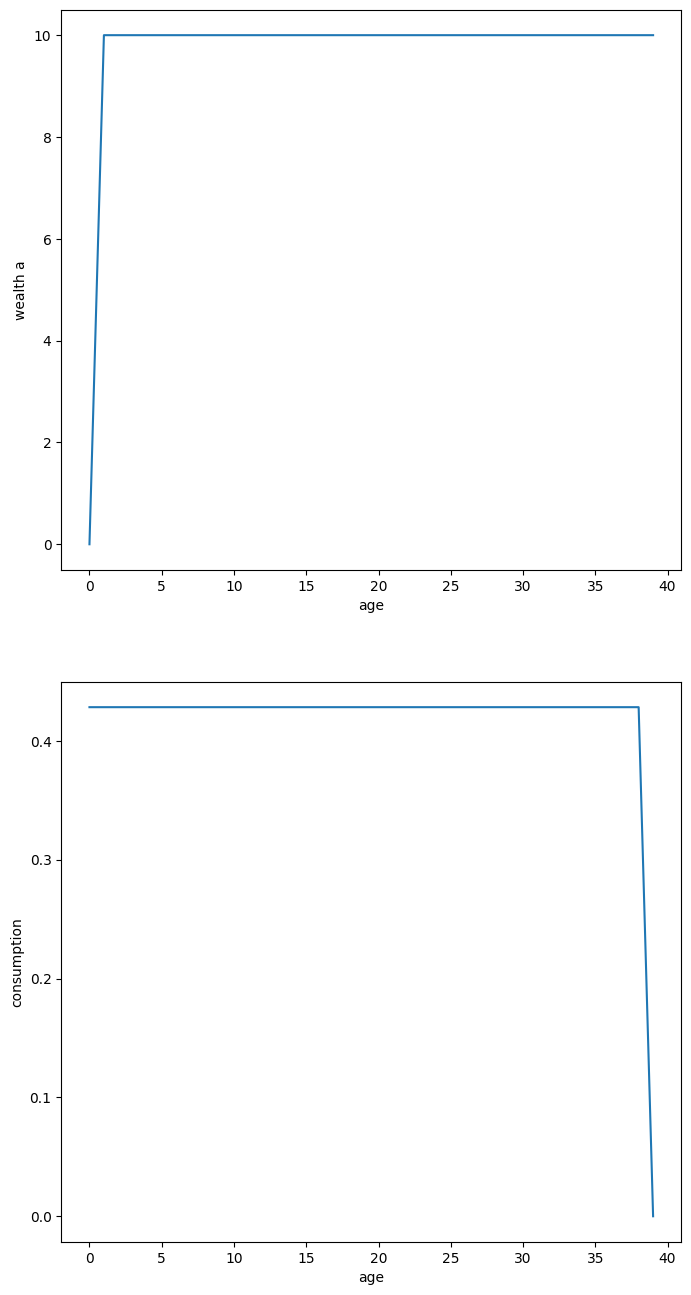

iter: 7; K change: 0.06; H change: 0.00; L change: 0.00
iter: 7; K: 7.84; H: 1.00; L: 0.20
iter: 7; Y: 0.67; tau: 0.15; T: 0.05
iter: 7, i: 40, k: 7.837852885764093
iter: 7, i: 39, k: 7.837852885764093
iter: 7, i: 38, k: 7.837852885764093
iter: 7, i: 37, k: 7.837852885764093
iter: 7, i: 36, k: 7.837852885764093
iter: 7, i: 35, k: 7.837852885764093
iter: 7, i: 34, k: 7.837852885764093
iter: 7, i: 33, k: 7.837852885764093
iter: 7, i: 32, k: 7.837852885764093
iter: 7, i: 31, k: 7.837852885764093
iter: 7, i: 30, k: 7.837852885764093
iter: 7, i: 29, k: 7.837852885764093
iter: 7, i: 28, k: 7.837852885764093
iter: 7, i: 27, k: 7.837852885764093
iter: 7, i: 26, k: 7.837852885764093
iter: 7, i: 25, k: 7.837852885764093
iter: 7, i: 24, k: 7.837852885764093
iter: 7, i: 23, k: 7.837852885764093
iter: 7, i: 22, k: 7.837852885764093
iter: 7, i: 21, k: 7.837852885764093
iter: 7, i: 20, k: 7.837852885764093
iter: 7, i: 19, k: 7.837852885764093
iter: 7, i: 18, k: 7.837852885764093
iter: 7, i: 17, k: 7.

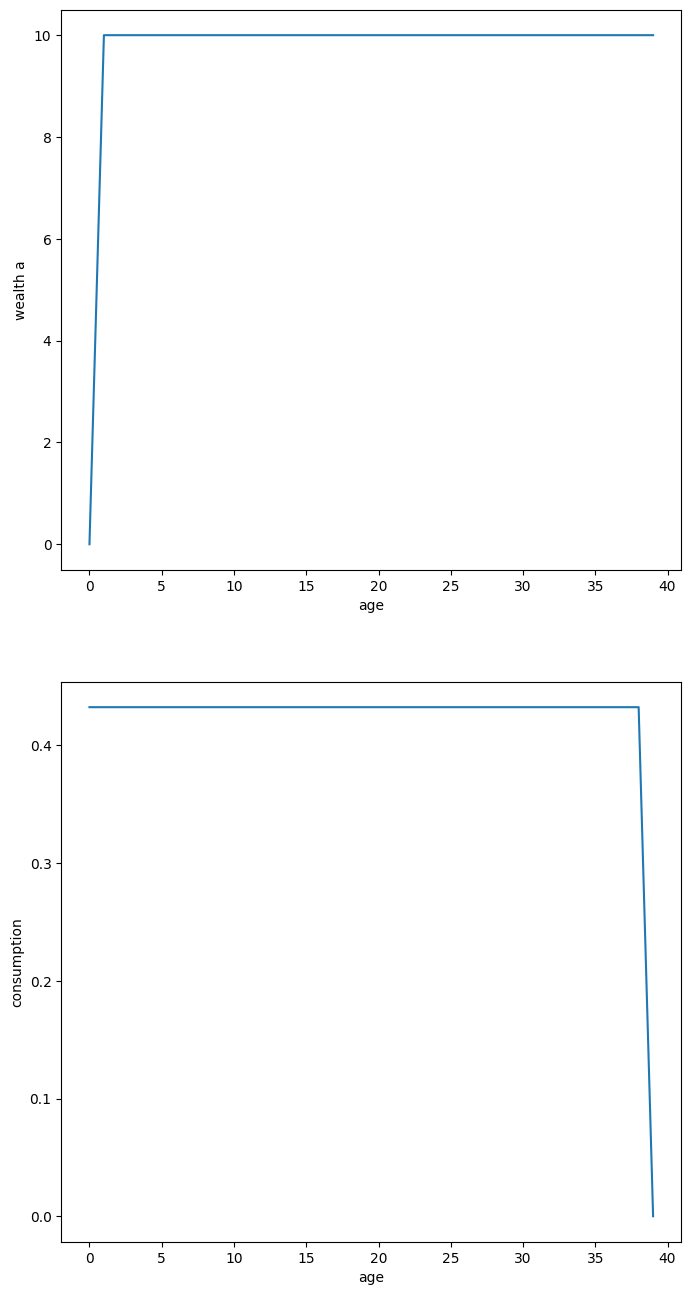

iter: 8; K change: 0.05; H change: 0.00; L change: 0.00
iter: 8; K: 8.22; H: 1.00; L: 0.20
iter: 8; Y: 0.68; tau: 0.15; T: 0.05
iter: 8, i: 40, k: 8.220282308611274
iter: 8, i: 39, k: 8.220282308611274
iter: 8, i: 38, k: 8.220282308611274
iter: 8, i: 37, k: 8.220282308611274
iter: 8, i: 36, k: 8.220282308611274
iter: 8, i: 35, k: 8.220282308611274
iter: 8, i: 34, k: 8.220282308611274
iter: 8, i: 33, k: 8.220282308611274
iter: 8, i: 32, k: 8.220282308611274
iter: 8, i: 31, k: 8.220282308611274
iter: 8, i: 30, k: 8.220282308611274
iter: 8, i: 29, k: 8.220282308611274
iter: 8, i: 28, k: 8.220282308611274
iter: 8, i: 27, k: 8.220282308611274
iter: 8, i: 26, k: 8.220282308611274
iter: 8, i: 25, k: 8.220282308611274
iter: 8, i: 24, k: 8.220282308611274
iter: 8, i: 23, k: 8.220282308611274
iter: 8, i: 22, k: 8.220282308611274
iter: 8, i: 21, k: 8.220282308611274
iter: 8, i: 20, k: 8.220282308611274
iter: 8, i: 19, k: 8.220282308611274
iter: 8, i: 18, k: 8.220282308611274
iter: 8, i: 17, k: 8.

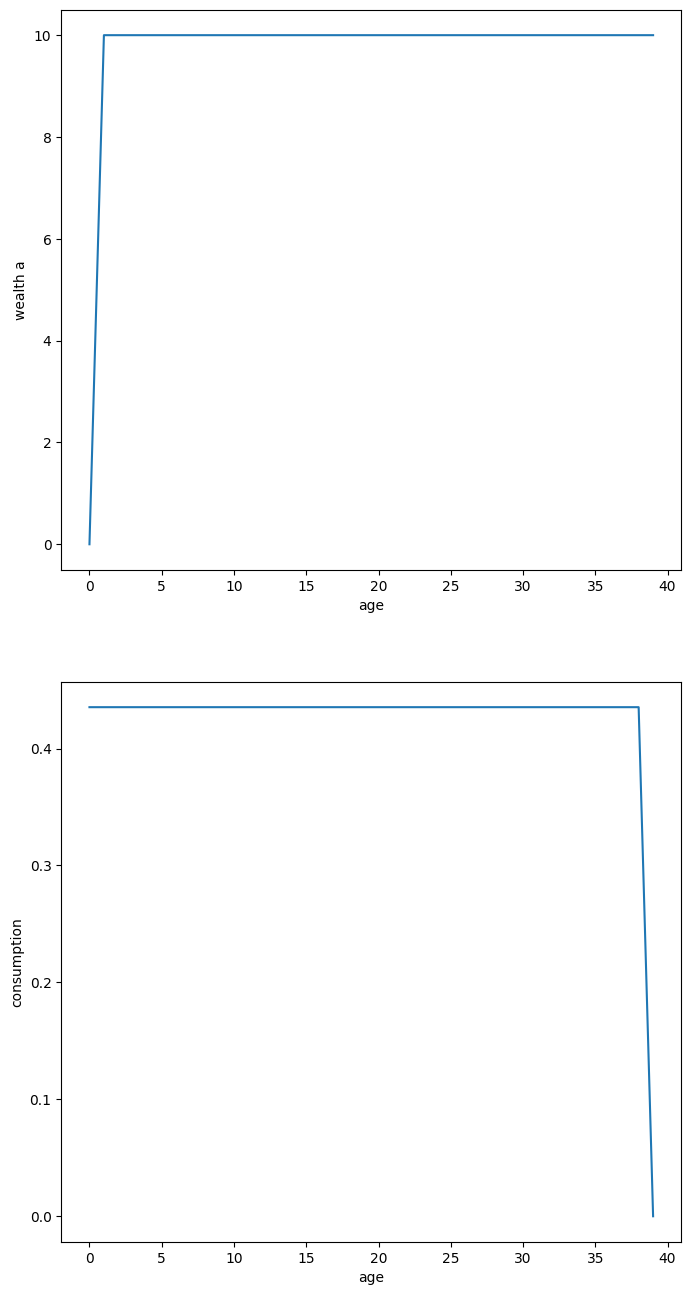

iter: 9; K change: 0.04; H change: 0.00; L change: 0.00
iter: 9; K: 8.53; H: 1.00; L: 0.20
iter: 9; Y: 0.69; tau: 0.15; T: 0.04
iter: 9, i: 40, k: 8.52622584688902
iter: 9, i: 39, k: 8.52622584688902
iter: 9, i: 38, k: 8.52622584688902
iter: 9, i: 37, k: 8.52622584688902
iter: 9, i: 36, k: 8.52622584688902
iter: 9, i: 35, k: 8.52622584688902
iter: 9, i: 34, k: 8.52622584688902
iter: 9, i: 33, k: 8.52622584688902
iter: 9, i: 32, k: 8.52622584688902
iter: 9, i: 31, k: 8.52622584688902
iter: 9, i: 30, k: 8.52622584688902
iter: 9, i: 29, k: 8.52622584688902
iter: 9, i: 28, k: 8.52622584688902
iter: 9, i: 27, k: 8.52622584688902
iter: 9, i: 26, k: 8.52622584688902
iter: 9, i: 25, k: 8.52622584688902
iter: 9, i: 24, k: 8.52622584688902
iter: 9, i: 23, k: 8.52622584688902
iter: 9, i: 22, k: 8.52622584688902
iter: 9, i: 21, k: 8.52622584688902
iter: 9, i: 20, k: 8.52622584688902
iter: 9, i: 19, k: 8.52622584688902
iter: 9, i: 18, k: 8.52622584688902
iter: 9, i: 17, k: 8.52622584688902
iter: 9,

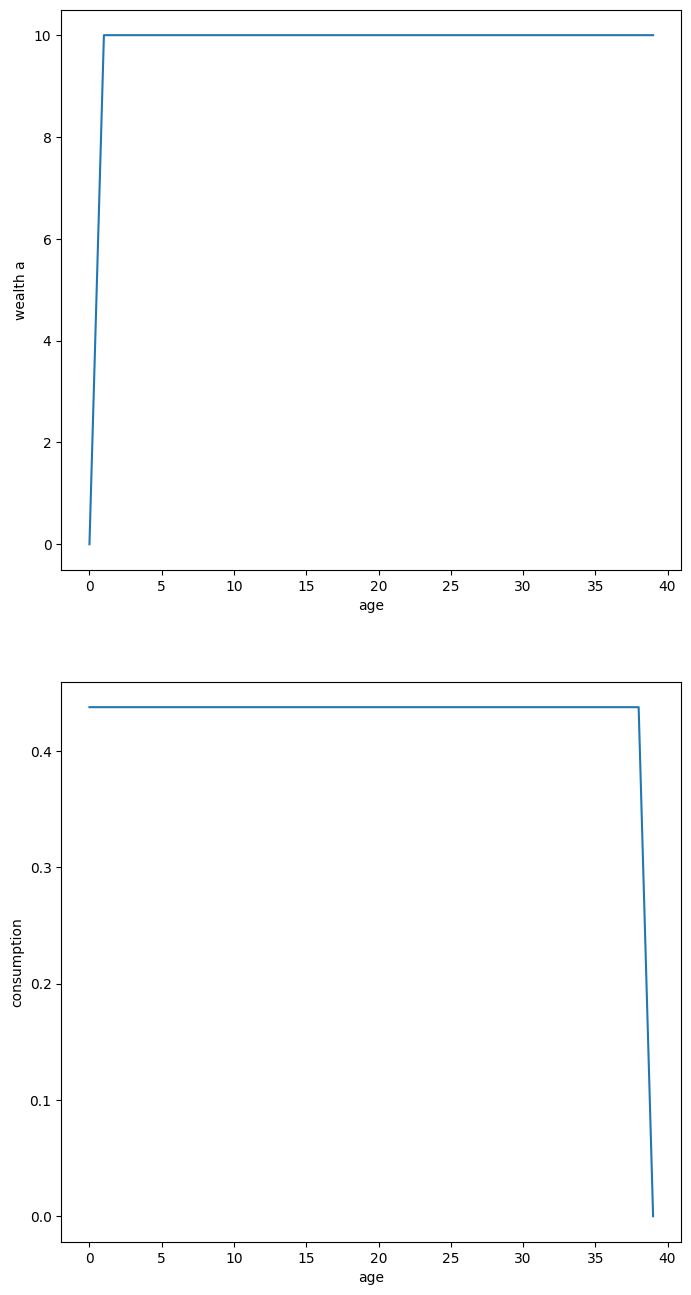

iter: 10; K change: 0.03; H change: 0.00; L change: 0.00
iter: 10; K: 8.77; H: 1.00; L: 0.20
iter: 10; Y: 0.70; tau: 0.15; T: 0.04
iter: 10, i: 40, k: 8.770980677511215
iter: 10, i: 39, k: 8.770980677511215
iter: 10, i: 38, k: 8.770980677511215
iter: 10, i: 37, k: 8.770980677511215
iter: 10, i: 36, k: 8.770980677511215
iter: 10, i: 35, k: 8.770980677511215
iter: 10, i: 34, k: 8.770980677511215
iter: 10, i: 33, k: 8.770980677511215
iter: 10, i: 32, k: 8.770980677511215
iter: 10, i: 31, k: 8.770980677511215
iter: 10, i: 30, k: 8.770980677511215
iter: 10, i: 29, k: 8.770980677511215
iter: 10, i: 28, k: 8.770980677511215
iter: 10, i: 27, k: 8.770980677511215
iter: 10, i: 26, k: 8.770980677511215
iter: 10, i: 25, k: 8.770980677511215
iter: 10, i: 24, k: 8.770980677511215
iter: 10, i: 23, k: 8.770980677511215
iter: 10, i: 22, k: 8.770980677511215
iter: 10, i: 21, k: 8.770980677511215
iter: 10, i: 20, k: 8.770980677511215
iter: 10, i: 19, k: 8.770980677511215
iter: 10, i: 18, k: 8.77098067751

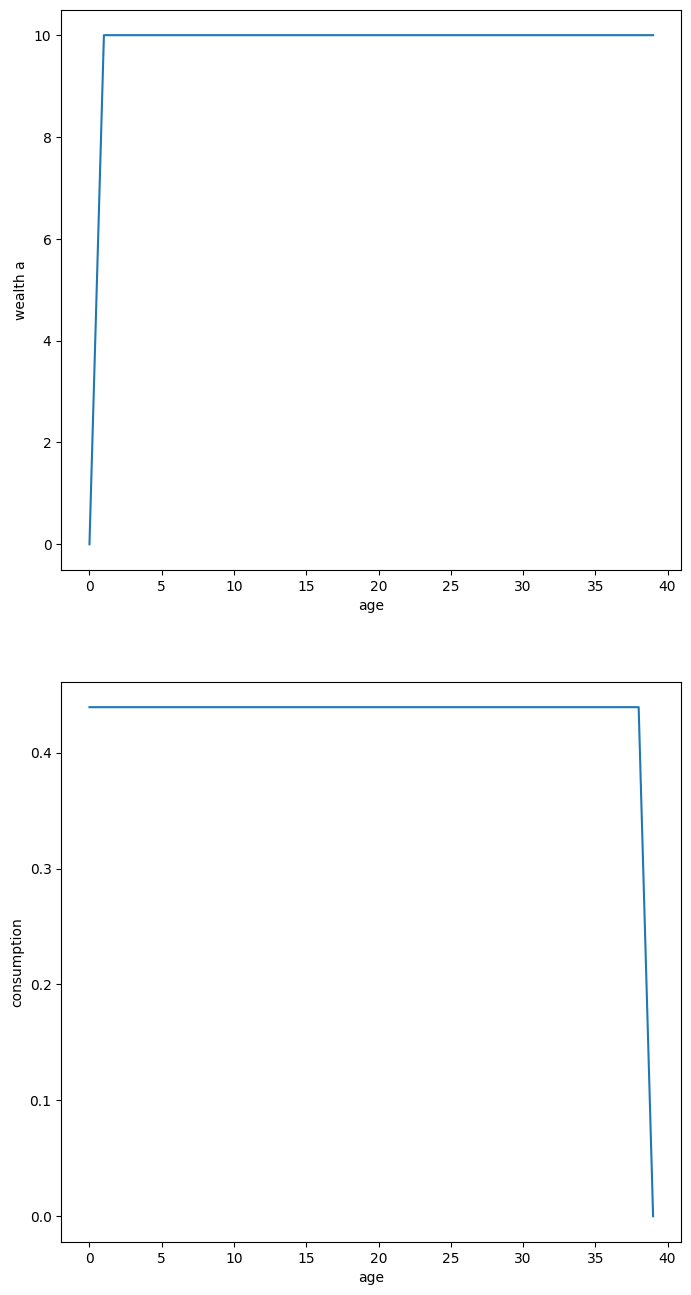

iter: 11; K change: 0.02; H change: 0.00; L change: 0.00
iter: 11; K: 8.97; H: 1.00; L: 0.20
iter: 11; Y: 0.70; tau: 0.15; T: 0.04
iter: 11, i: 40, k: 8.966784542008972
iter: 11, i: 39, k: 8.966784542008972
iter: 11, i: 38, k: 8.966784542008972
iter: 11, i: 37, k: 8.966784542008972
iter: 11, i: 36, k: 8.966784542008972
iter: 11, i: 35, k: 8.966784542008972
iter: 11, i: 34, k: 8.966784542008972
iter: 11, i: 33, k: 8.966784542008972
iter: 11, i: 32, k: 8.966784542008972
iter: 11, i: 31, k: 8.966784542008972
iter: 11, i: 30, k: 8.966784542008972
iter: 11, i: 29, k: 8.966784542008972
iter: 11, i: 28, k: 8.966784542008972
iter: 11, i: 27, k: 8.966784542008972
iter: 11, i: 26, k: 8.966784542008972
iter: 11, i: 25, k: 8.966784542008972
iter: 11, i: 24, k: 8.966784542008972
iter: 11, i: 23, k: 8.966784542008972
iter: 11, i: 22, k: 8.966784542008972
iter: 11, i: 21, k: 8.966784542008972
iter: 11, i: 20, k: 8.966784542008972
iter: 11, i: 19, k: 8.966784542008972
iter: 11, i: 18, k: 8.96678454200

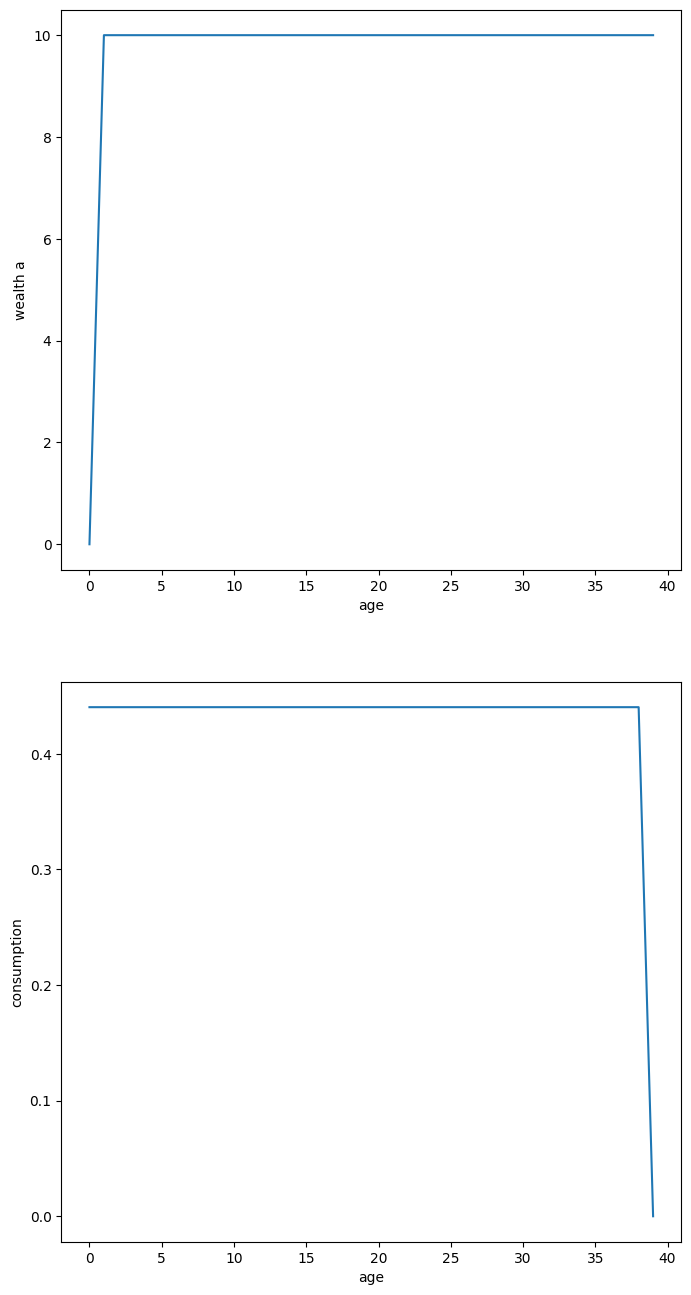

iter: 12; K change: 0.02; H change: 0.00; L change: 0.00
iter: 12; K: 9.12; H: 1.00; L: 0.20
iter: 12; Y: 0.71; tau: 0.15; T: 0.04
iter: 12, i: 40, k: 9.123427633607177
iter: 12, i: 39, k: 9.123427633607177
iter: 12, i: 38, k: 9.123427633607177
iter: 12, i: 37, k: 9.123427633607177
iter: 12, i: 36, k: 9.123427633607177
iter: 12, i: 35, k: 9.123427633607177
iter: 12, i: 34, k: 9.123427633607177
iter: 12, i: 33, k: 9.123427633607177
iter: 12, i: 32, k: 9.123427633607177
iter: 12, i: 31, k: 9.123427633607177
iter: 12, i: 30, k: 9.123427633607177
iter: 12, i: 29, k: 9.123427633607177
iter: 12, i: 28, k: 9.123427633607177
iter: 12, i: 27, k: 9.123427633607177
iter: 12, i: 26, k: 9.123427633607177
iter: 12, i: 25, k: 9.123427633607177
iter: 12, i: 24, k: 9.123427633607177
iter: 12, i: 23, k: 9.123427633607177
iter: 12, i: 22, k: 9.123427633607177
iter: 12, i: 21, k: 9.123427633607177
iter: 12, i: 20, k: 9.123427633607177
iter: 12, i: 19, k: 9.123427633607177
iter: 12, i: 18, k: 9.12342763360

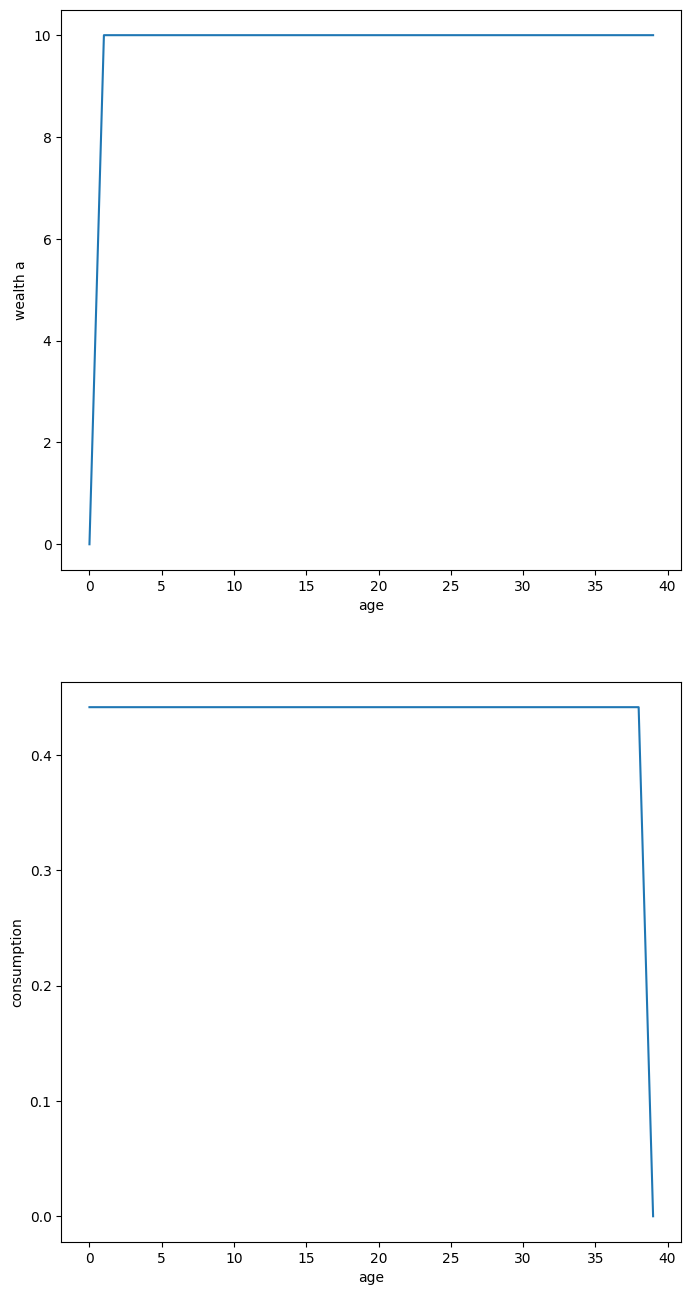

iter: 13; K change: 0.01; H change: 0.00; L change: 0.00
iter: 13; K: 9.25; H: 1.00; L: 0.20
iter: 13; Y: 0.71; tau: 0.15; T: 0.04
iter: 13, i: 40, k: 9.248742106885741
iter: 13, i: 39, k: 9.248742106885741
iter: 13, i: 38, k: 9.248742106885741
iter: 13, i: 37, k: 9.248742106885741
iter: 13, i: 36, k: 9.248742106885741
iter: 13, i: 35, k: 9.248742106885741
iter: 13, i: 34, k: 9.248742106885741
iter: 13, i: 33, k: 9.248742106885741
iter: 13, i: 32, k: 9.248742106885741
iter: 13, i: 31, k: 9.248742106885741
iter: 13, i: 30, k: 9.248742106885741
iter: 13, i: 29, k: 9.248742106885741
iter: 13, i: 28, k: 9.248742106885741
iter: 13, i: 27, k: 9.248742106885741
iter: 13, i: 26, k: 9.248742106885741
iter: 13, i: 25, k: 9.248742106885741
iter: 13, i: 24, k: 9.248742106885741
iter: 13, i: 23, k: 9.248742106885741
iter: 13, i: 22, k: 9.248742106885741
iter: 13, i: 21, k: 9.248742106885741
iter: 13, i: 20, k: 9.248742106885741
iter: 13, i: 19, k: 9.248742106885741
iter: 13, i: 18, k: 9.24874210688

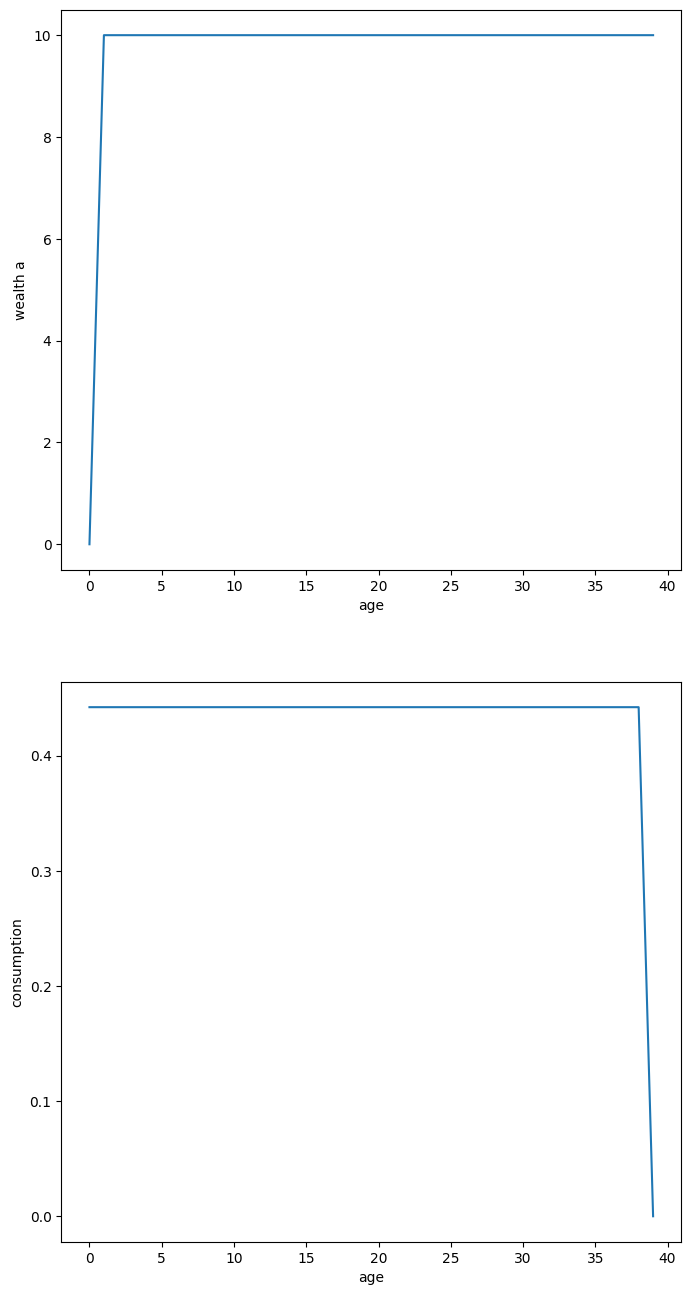

iter: 14; K change: 0.01; H change: 0.00; L change: 0.00
iter: 14; K: 9.35; H: 1.00; L: 0.20
iter: 14; Y: 0.71; tau: 0.15; T: 0.04
iter: 14, i: 40, k: 9.348993685508592
iter: 14, i: 39, k: 9.348993685508592
iter: 14, i: 38, k: 9.348993685508592
iter: 14, i: 37, k: 9.348993685508592
iter: 14, i: 36, k: 9.348993685508592
iter: 14, i: 35, k: 9.348993685508592
iter: 14, i: 34, k: 9.348993685508592
iter: 14, i: 33, k: 9.348993685508592
iter: 14, i: 32, k: 9.348993685508592
iter: 14, i: 31, k: 9.348993685508592
iter: 14, i: 30, k: 9.348993685508592
iter: 14, i: 29, k: 9.348993685508592
iter: 14, i: 28, k: 9.348993685508592
iter: 14, i: 27, k: 9.348993685508592
iter: 14, i: 26, k: 9.348993685508592
iter: 14, i: 25, k: 9.348993685508592
iter: 14, i: 24, k: 9.348993685508592
iter: 14, i: 23, k: 9.348993685508592
iter: 14, i: 22, k: 9.348993685508592
iter: 14, i: 21, k: 9.348993685508592
iter: 14, i: 20, k: 9.348993685508592
iter: 14, i: 19, k: 9.348993685508592
iter: 14, i: 18, k: 9.34899368550

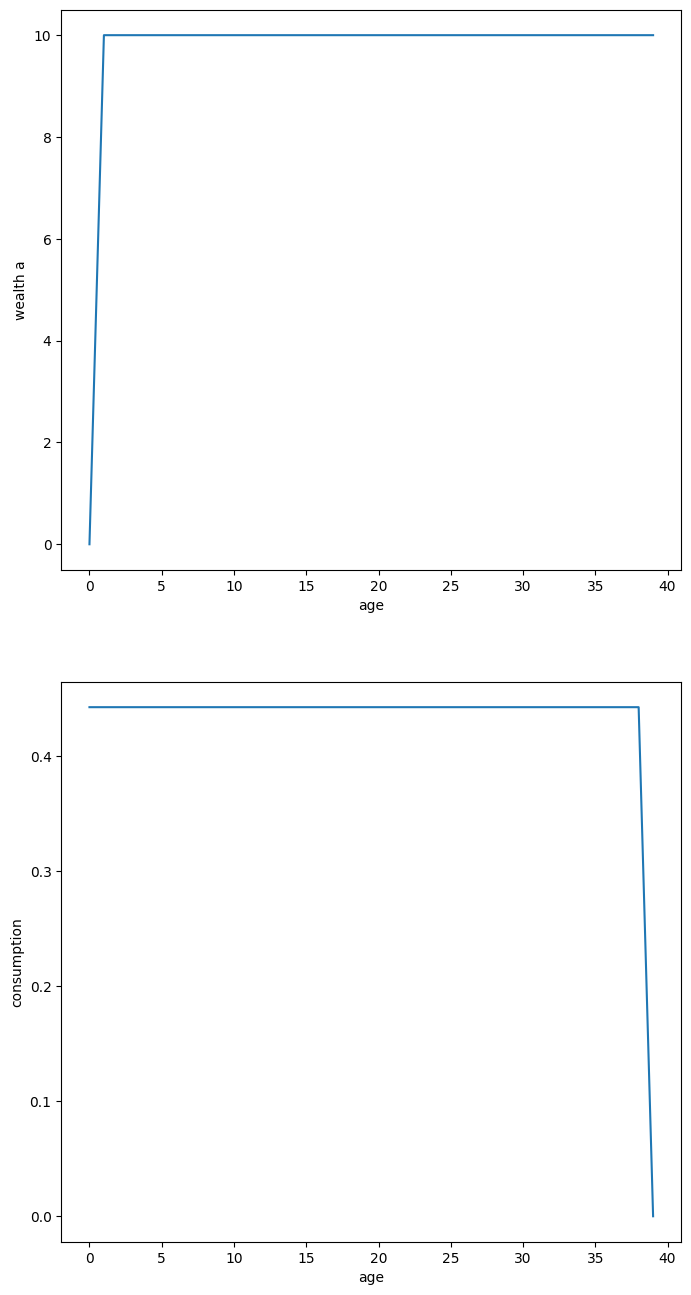

iter: 15; K change: 0.01; H change: 0.00; L change: 0.00
iter: 15; K: 9.43; H: 1.00; L: 0.20
iter: 15; Y: 0.71; tau: 0.15; T: 0.04
iter: 15, i: 40, k: 9.429194948406874
iter: 15, i: 39, k: 9.429194948406874
iter: 15, i: 38, k: 9.429194948406874
iter: 15, i: 37, k: 9.429194948406874
iter: 15, i: 36, k: 9.429194948406874
iter: 15, i: 35, k: 9.429194948406874
iter: 15, i: 34, k: 9.429194948406874
iter: 15, i: 33, k: 9.429194948406874
iter: 15, i: 32, k: 9.429194948406874
iter: 15, i: 31, k: 9.429194948406874
iter: 15, i: 30, k: 9.429194948406874
iter: 15, i: 29, k: 9.429194948406874
iter: 15, i: 28, k: 9.429194948406874
iter: 15, i: 27, k: 9.429194948406874
iter: 15, i: 26, k: 9.429194948406874
iter: 15, i: 25, k: 9.429194948406874
iter: 15, i: 24, k: 9.429194948406874
iter: 15, i: 23, k: 9.429194948406874
iter: 15, i: 22, k: 9.429194948406874
iter: 15, i: 21, k: 9.429194948406874
iter: 15, i: 20, k: 9.429194948406874
iter: 15, i: 19, k: 9.429194948406874
iter: 15, i: 18, k: 9.42919494840

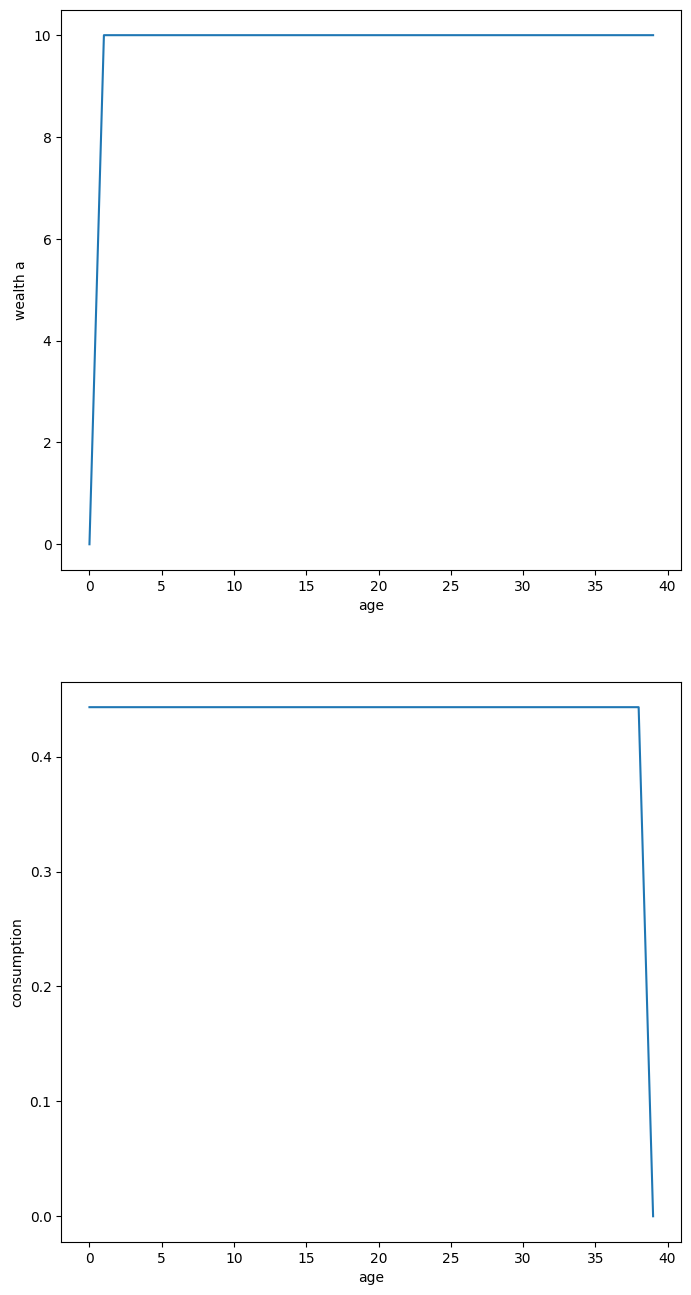

iter: 16; K change: 0.01; H change: 0.00; L change: 0.00
iter: 16; K: 9.49; H: 1.00; L: 0.20
iter: 16; Y: 0.71; tau: 0.15; T: 0.04
iter: 16, i: 40, k: 9.493355958725498
iter: 16, i: 39, k: 9.493355958725498
iter: 16, i: 38, k: 9.493355958725498
iter: 16, i: 37, k: 9.493355958725498
iter: 16, i: 36, k: 9.493355958725498
iter: 16, i: 35, k: 9.493355958725498
iter: 16, i: 34, k: 9.493355958725498
iter: 16, i: 33, k: 9.493355958725498
iter: 16, i: 32, k: 9.493355958725498
iter: 16, i: 31, k: 9.493355958725498
iter: 16, i: 30, k: 9.493355958725498
iter: 16, i: 29, k: 9.493355958725498
iter: 16, i: 28, k: 9.493355958725498
iter: 16, i: 27, k: 9.493355958725498
iter: 16, i: 26, k: 9.493355958725498
iter: 16, i: 25, k: 9.493355958725498
iter: 16, i: 24, k: 9.493355958725498
iter: 16, i: 23, k: 9.493355958725498
iter: 16, i: 22, k: 9.493355958725498
iter: 16, i: 21, k: 9.493355958725498
iter: 16, i: 20, k: 9.493355958725498
iter: 16, i: 19, k: 9.493355958725498
iter: 16, i: 18, k: 9.49335595872

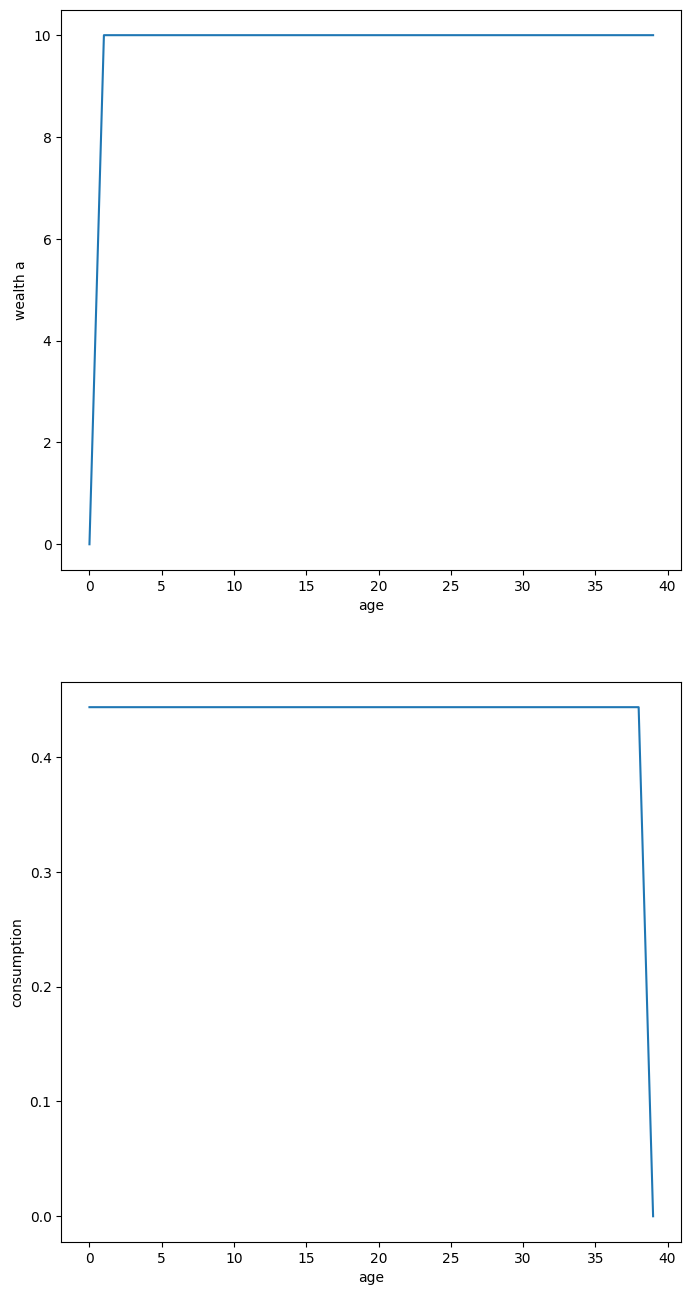

iter: 17; K change: 0.01; H change: 0.00; L change: 0.00
iter: 17; K: 9.54; H: 1.00; L: 0.20
iter: 17; Y: 0.72; tau: 0.15; T: 0.04
iter: 17, i: 40, k: 9.5446847669804
iter: 17, i: 39, k: 9.5446847669804
iter: 17, i: 38, k: 9.5446847669804
iter: 17, i: 37, k: 9.5446847669804
iter: 17, i: 36, k: 9.5446847669804
iter: 17, i: 35, k: 9.5446847669804
iter: 17, i: 34, k: 9.5446847669804
iter: 17, i: 33, k: 9.5446847669804
iter: 17, i: 32, k: 9.5446847669804
iter: 17, i: 31, k: 9.5446847669804
iter: 17, i: 30, k: 9.5446847669804
iter: 17, i: 29, k: 9.5446847669804
iter: 17, i: 28, k: 9.5446847669804
iter: 17, i: 27, k: 9.5446847669804
iter: 17, i: 26, k: 9.5446847669804
iter: 17, i: 25, k: 9.5446847669804
iter: 17, i: 24, k: 9.5446847669804
iter: 17, i: 23, k: 9.5446847669804
iter: 17, i: 22, k: 9.5446847669804
iter: 17, i: 21, k: 9.5446847669804
iter: 17, i: 20, k: 9.5446847669804
iter: 17, i: 19, k: 9.5446847669804
iter: 17, i: 18, k: 9.5446847669804
iter: 17, i: 17, k: 9.5446847669804
iter:

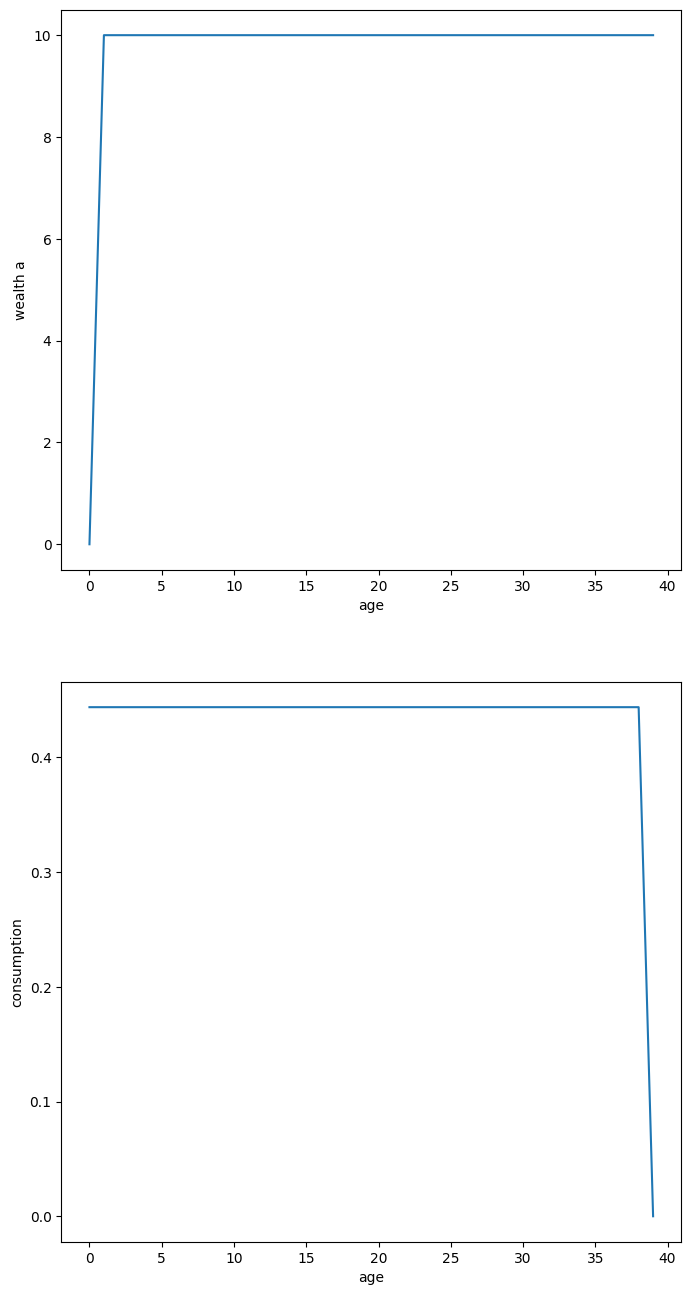

iter: 18; K change: 0.00; H change: 0.00; L change: 0.00
iter: 18; K: 9.59; H: 1.00; L: 0.20
iter: 18; Y: 0.72; tau: 0.15; T: 0.04
iter: 18, i: 40, k: 9.58574781358432
iter: 18, i: 39, k: 9.58574781358432
iter: 18, i: 38, k: 9.58574781358432
iter: 18, i: 37, k: 9.58574781358432
iter: 18, i: 36, k: 9.58574781358432
iter: 18, i: 35, k: 9.58574781358432
iter: 18, i: 34, k: 9.58574781358432
iter: 18, i: 33, k: 9.58574781358432
iter: 18, i: 32, k: 9.58574781358432
iter: 18, i: 31, k: 9.58574781358432
iter: 18, i: 30, k: 9.58574781358432
iter: 18, i: 29, k: 9.58574781358432
iter: 18, i: 28, k: 9.58574781358432
iter: 18, i: 27, k: 9.58574781358432
iter: 18, i: 26, k: 9.58574781358432
iter: 18, i: 25, k: 9.58574781358432
iter: 18, i: 24, k: 9.58574781358432
iter: 18, i: 23, k: 9.58574781358432
iter: 18, i: 22, k: 9.58574781358432
iter: 18, i: 21, k: 9.58574781358432
iter: 18, i: 20, k: 9.58574781358432
iter: 18, i: 19, k: 9.58574781358432
iter: 18, i: 18, k: 9.58574781358432
iter: 18, i: 17, k

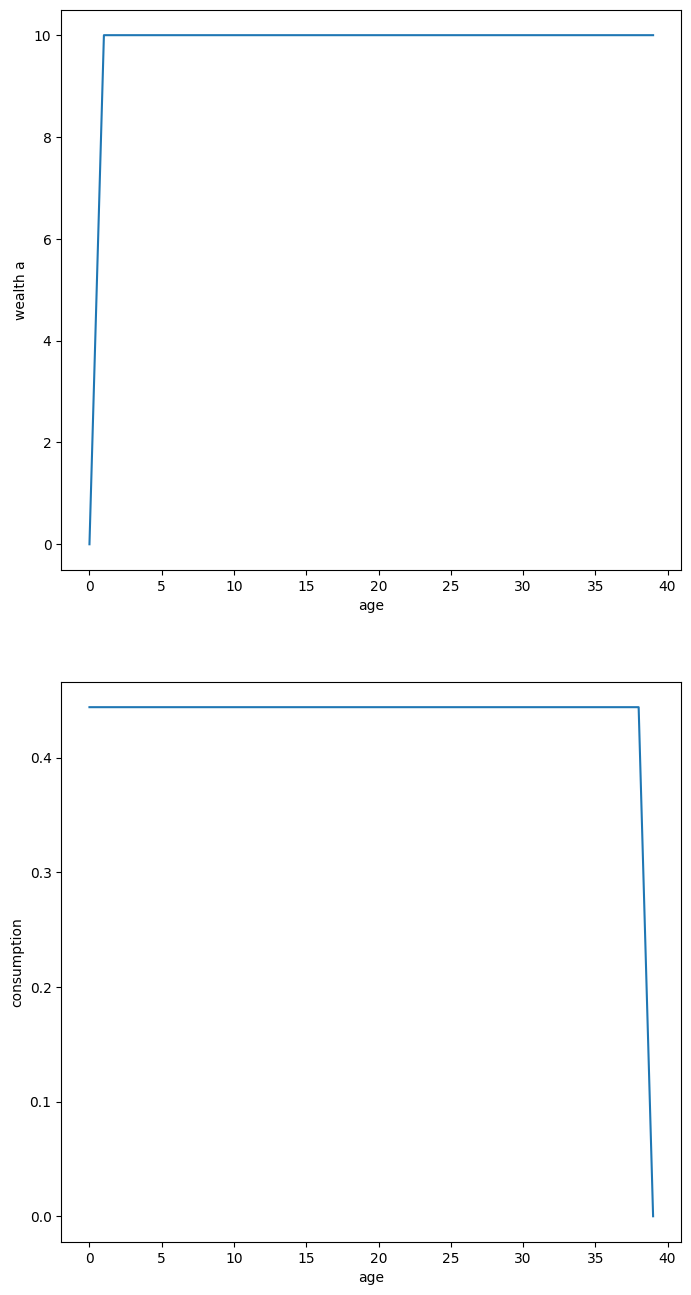

iter: 19; K change: 0.00; H change: 0.00; L change: 0.00
iter: 19; K: 9.62; H: 1.00; L: 0.20
iter: 19; Y: 0.72; tau: 0.15; T: 0.04
iter: 19, i: 40, k: 9.618598250867455
iter: 19, i: 39, k: 9.618598250867455
iter: 19, i: 38, k: 9.618598250867455
iter: 19, i: 37, k: 9.618598250867455
iter: 19, i: 36, k: 9.618598250867455
iter: 19, i: 35, k: 9.618598250867455
iter: 19, i: 34, k: 9.618598250867455
iter: 19, i: 33, k: 9.618598250867455
iter: 19, i: 32, k: 9.618598250867455
iter: 19, i: 31, k: 9.618598250867455
iter: 19, i: 30, k: 9.618598250867455
iter: 19, i: 29, k: 9.618598250867455
iter: 19, i: 28, k: 9.618598250867455
iter: 19, i: 27, k: 9.618598250867455
iter: 19, i: 26, k: 9.618598250867455
iter: 19, i: 25, k: 9.618598250867455
iter: 19, i: 24, k: 9.618598250867455
iter: 19, i: 23, k: 9.618598250867455
iter: 19, i: 22, k: 9.618598250867455
iter: 19, i: 21, k: 9.618598250867455
iter: 19, i: 20, k: 9.618598250867455
iter: 19, i: 19, k: 9.618598250867455
iter: 19, i: 18, k: 9.61859825086

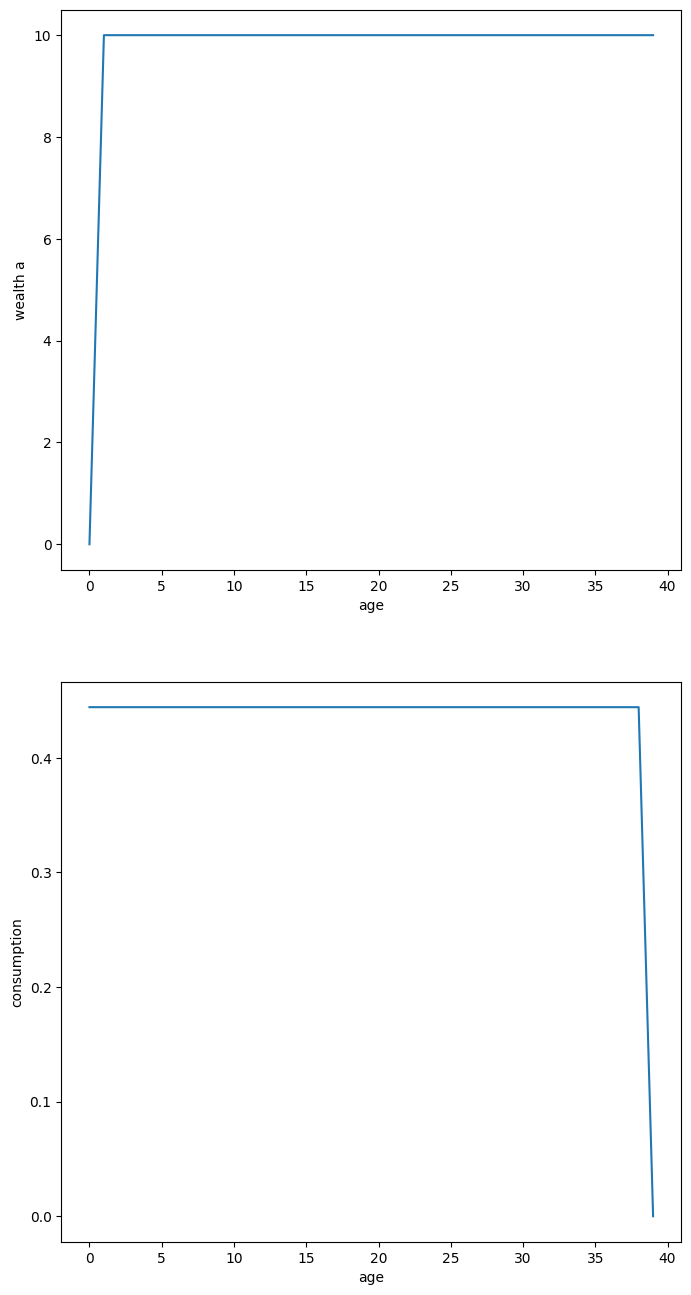

iter: 20; K change: 0.00; H change: 0.00; L change: 0.00
iter: 20; K: 9.64; H: 1.00; L: 0.20
iter: 20; Y: 0.72; tau: 0.15; T: 0.03
iter: 20, i: 40, k: 9.644878600693964
iter: 20, i: 39, k: 9.644878600693964
iter: 20, i: 38, k: 9.644878600693964
iter: 20, i: 37, k: 9.644878600693964
iter: 20, i: 36, k: 9.644878600693964
iter: 20, i: 35, k: 9.644878600693964
iter: 20, i: 34, k: 9.644878600693964
iter: 20, i: 33, k: 9.644878600693964
iter: 20, i: 32, k: 9.644878600693964
iter: 20, i: 31, k: 9.644878600693964
iter: 20, i: 30, k: 9.644878600693964
iter: 20, i: 29, k: 9.644878600693964
iter: 20, i: 28, k: 9.644878600693964
iter: 20, i: 27, k: 9.644878600693964
iter: 20, i: 26, k: 9.644878600693964
iter: 20, i: 25, k: 9.644878600693964
iter: 20, i: 24, k: 9.644878600693964
iter: 20, i: 23, k: 9.644878600693964
iter: 20, i: 22, k: 9.644878600693964
iter: 20, i: 21, k: 9.644878600693964
iter: 20, i: 20, k: 9.644878600693964
iter: 20, i: 19, k: 9.644878600693964
iter: 20, i: 18, k: 9.64487860069

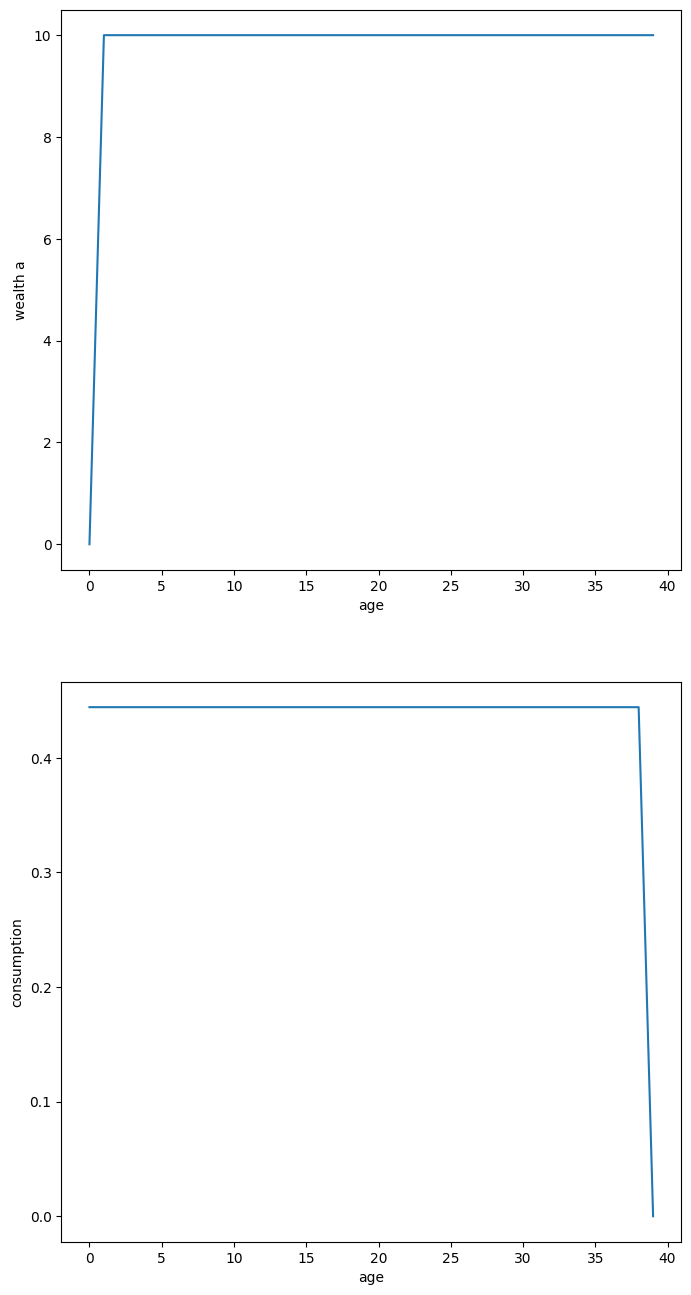

iter: 21; K change: 0.00; H change: 0.00; L change: 0.00
iter: 21; K: 9.67; H: 1.00; L: 0.20
iter: 21; Y: 0.72; tau: 0.15; T: 0.03
iter: 21, i: 40, k: 9.665902880555171
iter: 21, i: 39, k: 9.665902880555171
iter: 21, i: 38, k: 9.665902880555171
iter: 21, i: 37, k: 9.665902880555171
iter: 21, i: 36, k: 9.665902880555171
iter: 21, i: 35, k: 9.665902880555171
iter: 21, i: 34, k: 9.665902880555171
iter: 21, i: 33, k: 9.665902880555171
iter: 21, i: 32, k: 9.665902880555171
iter: 21, i: 31, k: 9.665902880555171
iter: 21, i: 30, k: 9.665902880555171
iter: 21, i: 29, k: 9.665902880555171
iter: 21, i: 28, k: 9.665902880555171
iter: 21, i: 27, k: 9.665902880555171
iter: 21, i: 26, k: 9.665902880555171
iter: 21, i: 25, k: 9.665902880555171
iter: 21, i: 24, k: 9.665902880555171
iter: 21, i: 23, k: 9.665902880555171
iter: 21, i: 22, k: 9.665902880555171
iter: 21, i: 21, k: 9.665902880555171
iter: 21, i: 20, k: 9.665902880555171
iter: 21, i: 19, k: 9.665902880555171
iter: 21, i: 18, k: 9.66590288055

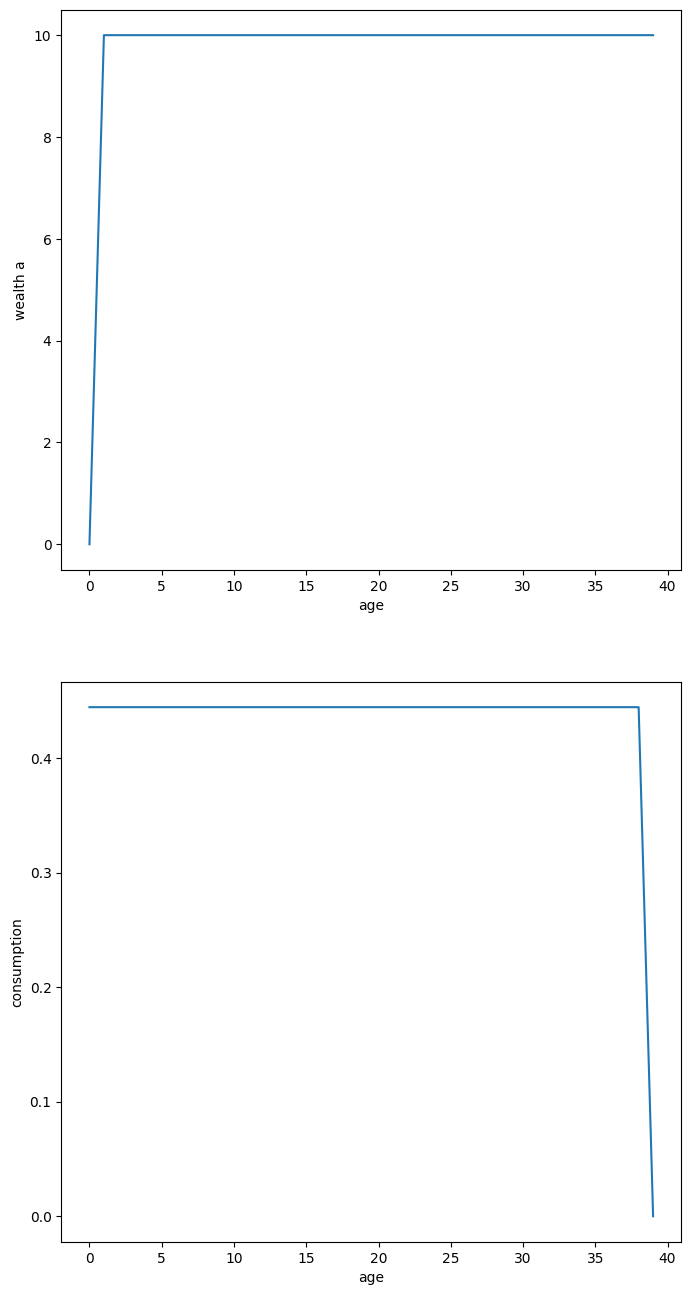

iter: 22; K change: 0.00; H change: 0.00; L change: 0.00
iter: 22; K: 9.68; H: 1.00; L: 0.20
iter: 22; Y: 0.72; tau: 0.15; T: 0.03
iter: 22, i: 40, k: 9.682722304444138
iter: 22, i: 39, k: 9.682722304444138
iter: 22, i: 38, k: 9.682722304444138
iter: 22, i: 37, k: 9.682722304444138
iter: 22, i: 36, k: 9.682722304444138
iter: 22, i: 35, k: 9.682722304444138
iter: 22, i: 34, k: 9.682722304444138
iter: 22, i: 33, k: 9.682722304444138
iter: 22, i: 32, k: 9.682722304444138
iter: 22, i: 31, k: 9.682722304444138
iter: 22, i: 30, k: 9.682722304444138
iter: 22, i: 29, k: 9.682722304444138
iter: 22, i: 28, k: 9.682722304444138
iter: 22, i: 27, k: 9.682722304444138
iter: 22, i: 26, k: 9.682722304444138
iter: 22, i: 25, k: 9.682722304444138
iter: 22, i: 24, k: 9.682722304444138
iter: 22, i: 23, k: 9.682722304444138
iter: 22, i: 22, k: 9.682722304444138
iter: 22, i: 21, k: 9.682722304444138
iter: 22, i: 20, k: 9.682722304444138
iter: 22, i: 19, k: 9.682722304444138
iter: 22, i: 18, k: 9.68272230444

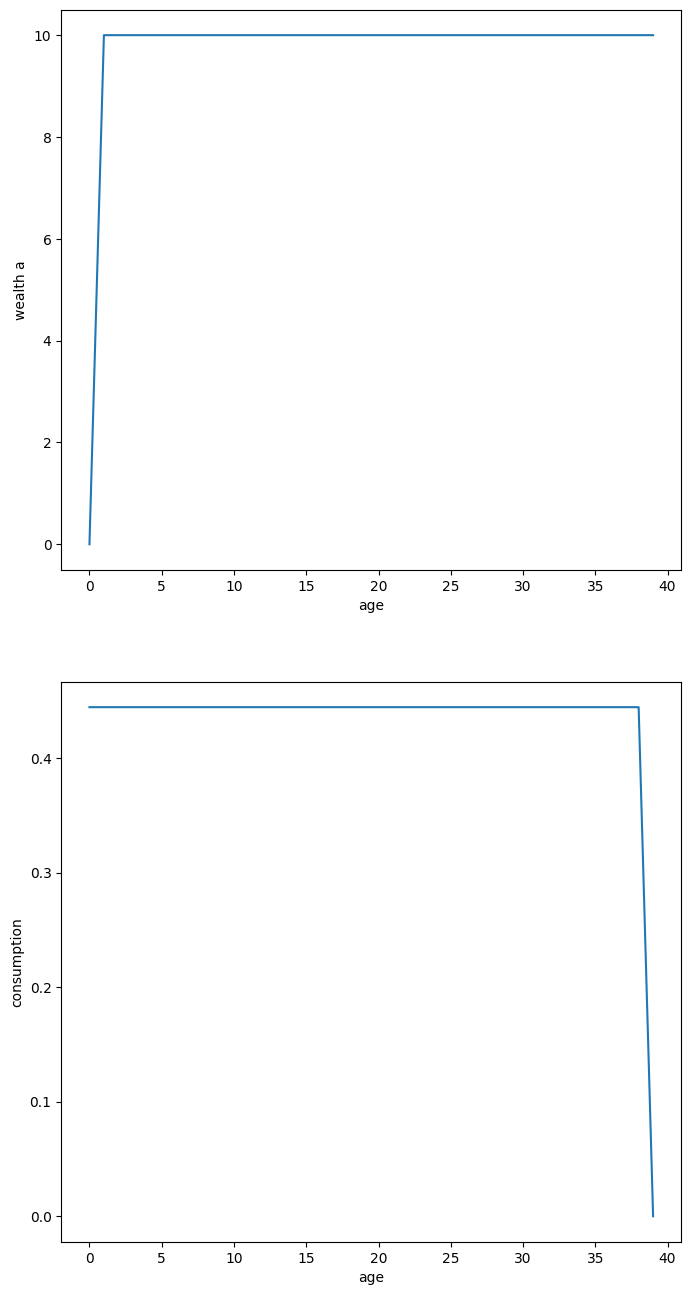

iter: 23; K change: 0.00; H change: 0.00; L change: 0.00
iter: 23; K: 9.70; H: 1.00; L: 0.20
iter: 23; Y: 0.72; tau: 0.15; T: 0.03
iter: 23, i: 40, k: 9.69617784355531
iter: 23, i: 39, k: 9.69617784355531
iter: 23, i: 38, k: 9.69617784355531
iter: 23, i: 37, k: 9.69617784355531
iter: 23, i: 36, k: 9.69617784355531
iter: 23, i: 35, k: 9.69617784355531
iter: 23, i: 34, k: 9.69617784355531
iter: 23, i: 33, k: 9.69617784355531
iter: 23, i: 32, k: 9.69617784355531
iter: 23, i: 31, k: 9.69617784355531
iter: 23, i: 30, k: 9.69617784355531
iter: 23, i: 29, k: 9.69617784355531
iter: 23, i: 28, k: 9.69617784355531
iter: 23, i: 27, k: 9.69617784355531
iter: 23, i: 26, k: 9.69617784355531
iter: 23, i: 25, k: 9.69617784355531
iter: 23, i: 24, k: 9.69617784355531
iter: 23, i: 23, k: 9.69617784355531
iter: 23, i: 22, k: 9.69617784355531
iter: 23, i: 21, k: 9.69617784355531
iter: 23, i: 20, k: 9.69617784355531
iter: 23, i: 19, k: 9.69617784355531
iter: 23, i: 18, k: 9.69617784355531
iter: 23, i: 17, k

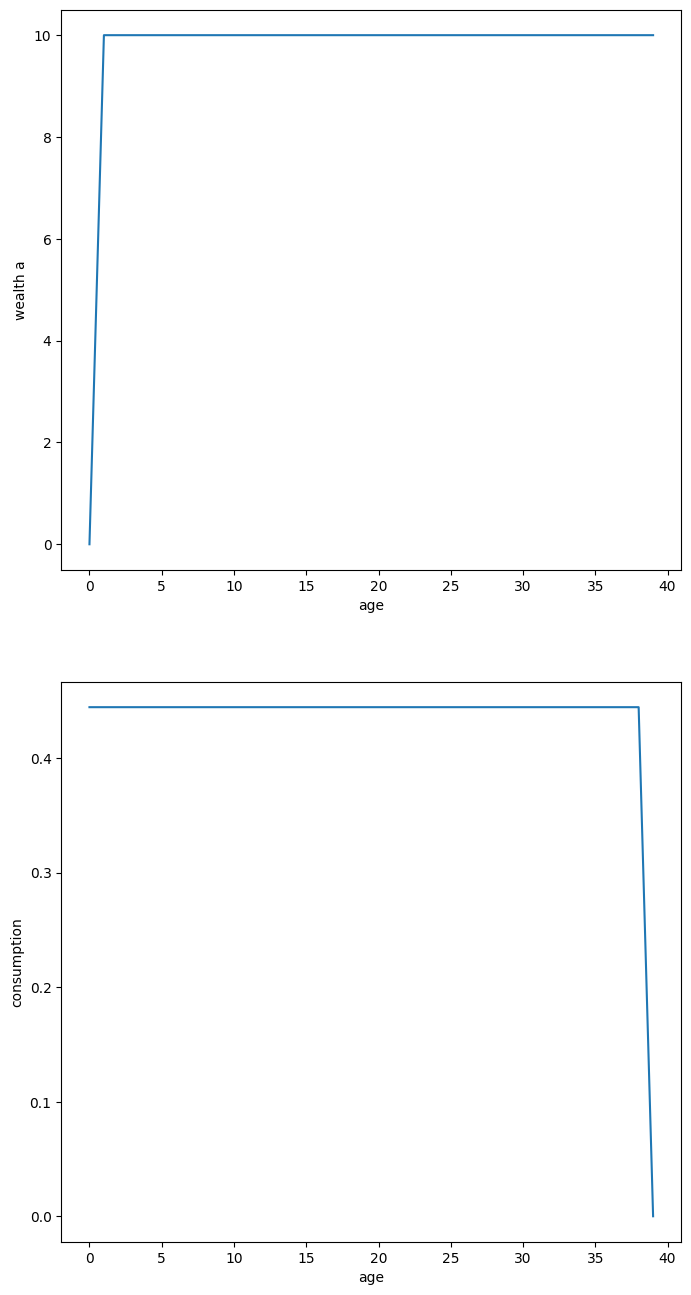

iter: 24; K change: 0.00; H change: 0.00; L change: 0.00
iter: 24; K: 9.71; H: 1.00; L: 0.20
iter: 24; Y: 0.72; tau: 0.15; T: 0.03
iter: 24, i: 40, k: 9.706942274844248
iter: 24, i: 39, k: 9.706942274844248
iter: 24, i: 38, k: 9.706942274844248
iter: 24, i: 37, k: 9.706942274844248
iter: 24, i: 36, k: 9.706942274844248
iter: 24, i: 35, k: 9.706942274844248
iter: 24, i: 34, k: 9.706942274844248
iter: 24, i: 33, k: 9.706942274844248
iter: 24, i: 32, k: 9.706942274844248
iter: 24, i: 31, k: 9.706942274844248
iter: 24, i: 30, k: 9.706942274844248
iter: 24, i: 29, k: 9.706942274844248
iter: 24, i: 28, k: 9.706942274844248
iter: 24, i: 27, k: 9.706942274844248
iter: 24, i: 26, k: 9.706942274844248
iter: 24, i: 25, k: 9.706942274844248
iter: 24, i: 24, k: 9.706942274844248
iter: 24, i: 23, k: 9.706942274844248
iter: 24, i: 22, k: 9.706942274844248
iter: 24, i: 21, k: 9.706942274844248
iter: 24, i: 20, k: 9.706942274844248
iter: 24, i: 19, k: 9.706942274844248
iter: 24, i: 18, k: 9.70694227484

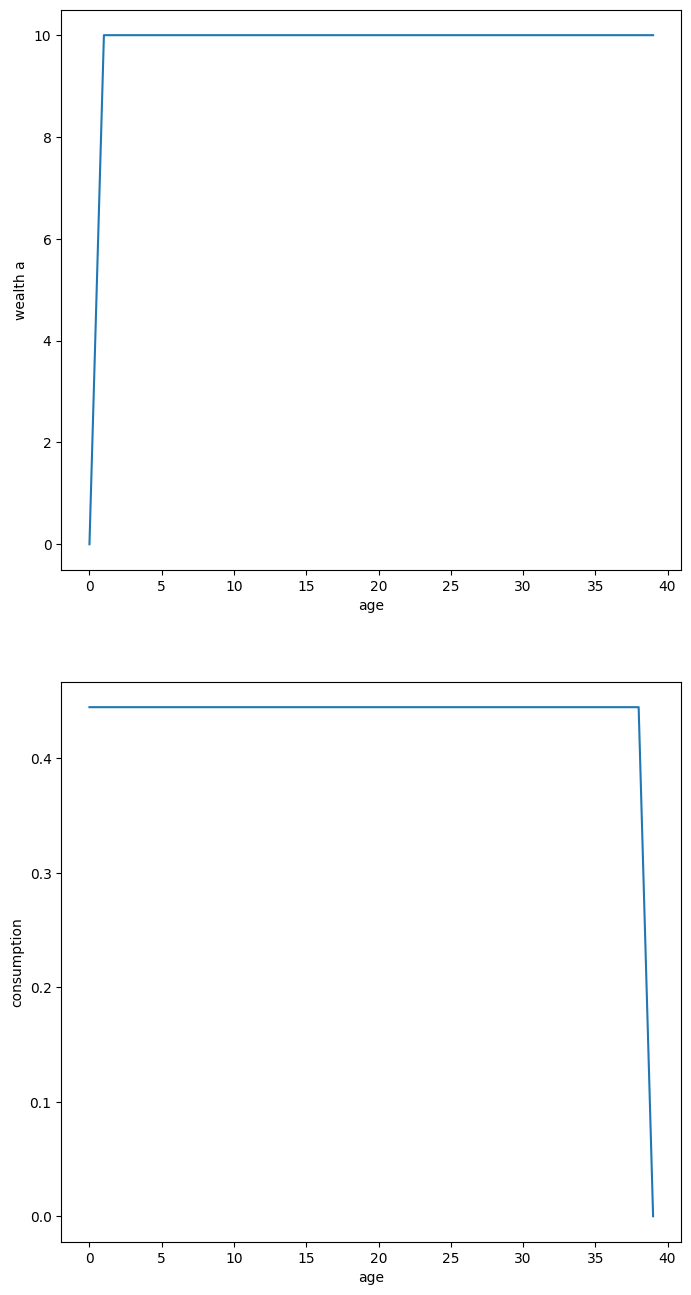

iter: 25; K change: 0.00; H change: 0.00; L change: 0.00
iter: 25; K: 9.72; H: 1.00; L: 0.20
iter: 25; Y: 0.72; tau: 0.15; T: 0.03
iter: 25, i: 40, k: 9.7155538198754
iter: 25, i: 39, k: 9.7155538198754
iter: 25, i: 38, k: 9.7155538198754
iter: 25, i: 37, k: 9.7155538198754
iter: 25, i: 36, k: 9.7155538198754
iter: 25, i: 35, k: 9.7155538198754
iter: 25, i: 34, k: 9.7155538198754
iter: 25, i: 33, k: 9.7155538198754
iter: 25, i: 32, k: 9.7155538198754
iter: 25, i: 31, k: 9.7155538198754
iter: 25, i: 30, k: 9.7155538198754
iter: 25, i: 29, k: 9.7155538198754
iter: 25, i: 28, k: 9.7155538198754
iter: 25, i: 27, k: 9.7155538198754
iter: 25, i: 26, k: 9.7155538198754
iter: 25, i: 25, k: 9.7155538198754
iter: 25, i: 24, k: 9.7155538198754
iter: 25, i: 23, k: 9.7155538198754
iter: 25, i: 22, k: 9.7155538198754
iter: 25, i: 21, k: 9.7155538198754
iter: 25, i: 20, k: 9.7155538198754
iter: 25, i: 19, k: 9.7155538198754
iter: 25, i: 18, k: 9.7155538198754
iter: 25, i: 17, k: 9.7155538198754
iter:

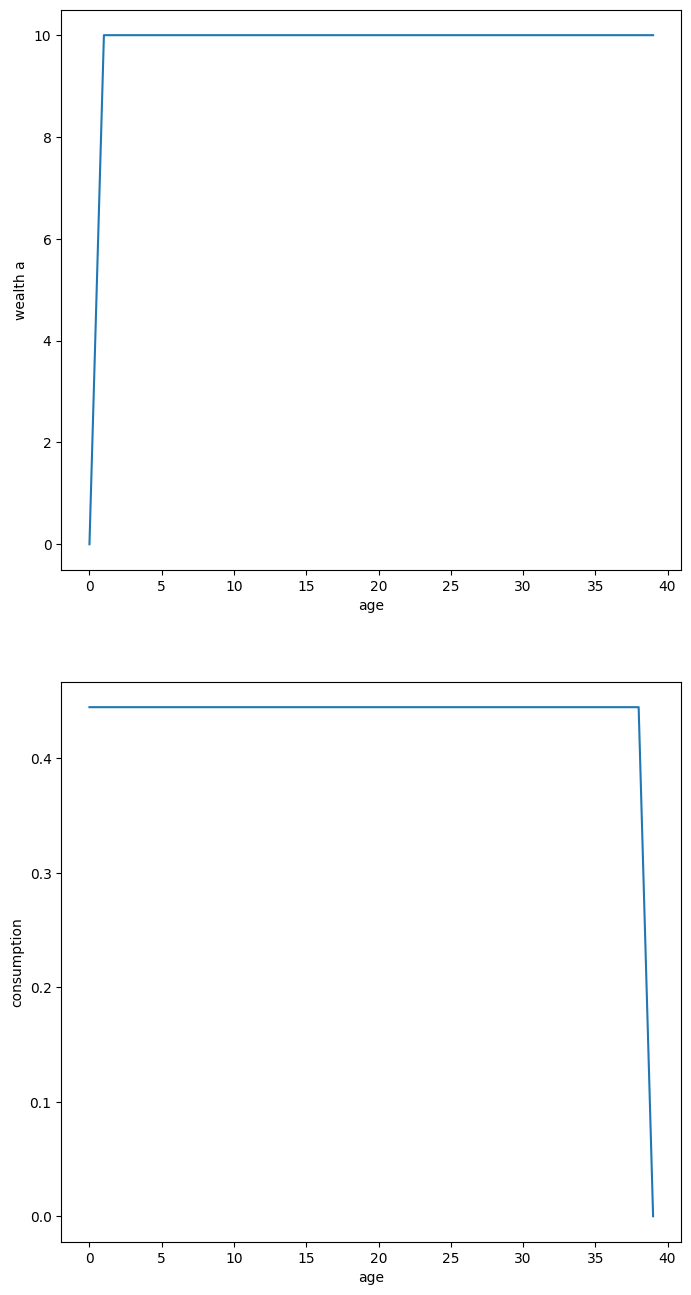

In [126]:
iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,3))

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance:
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar)
  L_diff = abs((L_bar - L_old) / L_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}")

  #calculate variables
  w = wage_rate(K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)

  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")

  #set the old state variables to be previous iteration state variables
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  state_var_iter_array[iteration, 0] = K_old
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old

  value_array = np.zeros((na, periods + 1)) #vw initialize the agents' value function array
  k_optimal_array = np.zeros((na, periods)) #initialize the optimal capital array
  c_optimal_array = np.zeros((na, periods)) #initialize the optimal consumption array
  l_optimal_array = np.zeros((na, periods)) #initialize the optimal labor array
  h_optimal_array = np.zeros((na, periods)) #initialize the optimal child human capital array
  hc_optimal_array = np.zeros((na, child_periods)) #initialize the optimal child human capital array


  #compute last period value function st eq. 15
  # for i in range(na):
  #   c = (1-tau)*w*h*l + (1+r)*k_prev - max(0, tau * r * k_prev) + T - k 
  #   value_array[i, periods - 1] = utility(k)
  #   c_optimal_array[i, periods - 1]

  #compute policy function
  for i in range(periods, 0, -1): #loop backwards from age 60 to 0
    print(f"iter: {iteration}, i: {i}, k: {K_bar}")
    vr_polate = interpolate.interp1d(k_grid, value_array[:,i], fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i

    m0 = 0

    for j in range(na): #iteration within this age loop
      k0 = k_grid[j]

      ax = 0
      bx = -1
      cx = -2
      v0 = neg
      m = max(-1, m0-2)

      while (ax > bx or bx > cx):
        m += 1

        v1 = value_function(k = k_grid[m], k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T)

        if v1 > v0:
          if m == 0:
            ax = k_grid[m]
            bx = k_grid[m]

          else:
            bx = k_grid[m]
            ax = k_grid[m-1]

          v0 = v1
          m0 = m

        else:
          cx = k_grid[m]

        if m==na-1:
          ax = k_grid[m-1]
          bx = k_grid[m] 
          cx = k_grid[m] 
        

      if ax==bx:  # corner solution: a'=0?
          if value_function(k = ax, k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T) > value_function(k = k_eps, k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T):
            k_optimal_array[j,i-1]=0
          else:
            k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs,
                k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T).find_max()
                
      elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
          if value_function(k = k_grid[na-1], k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T) > value_function(k = k_grid[na-1] - k_eps, k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T):
            k_optimal_array[j,i-1] = k_grid[na-1]
          else:
            k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
                k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T).find_max()        
        
      else:
          k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
                k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T).find_max()
            

      k1 = k_optimal_array[j,i-1]
      value_array[j,i-1] = value_function(k_optimal_array[j,i-1], k_prev = k0, l = l, h = h, w = w, r = r, tau = tau, T = T)
      c_optimal_array[j,i-1] = (1-tau)*w*h*l + r*k0 - tau*r*max(k0, 0) + T - k1
      # print(f"iter: {iteration}, i: {i}, k opt: {k1}")



      # if iteration==0 and i==10:
            
      #       plt.xlabel('wealth a')
      #       plt.ylabel('value function of the worker at age 10')
      #       plt.plot(k_grid,value_array[:,i-1])
      #       plt.show()
            
            
      #       plt.xlabel('wealth a')
      #       plt.ylabel('savings of the worker at age 10 year')
      #       plt.plot(k_grid,k_optimal_array[:,i-1]-a)
      #       plt.show()
            
            
      #       plt.xlabel('wealth a')
      #       plt.ylabel('consumption of the worker at age 10')
      #       plt.plot(k_grid,c_optimal_array[:,i-1])
      #       plt.show()
        
        
      #       # plt.xlabel('wealth a')
      #       # plt.ylabel('labor supply of the worker at age 10')
      #       # plt.plot(a,nwopt[:,i-1])
      #       # plt.show()





  k_gen = np.zeros(periods)
  l_gen = np.zeros(periods)
  c_gen = np.zeros(periods)

  k_gen[0] = k_start

  for q in range(periods - 1):
    a_polate = interpolate.interp1d(k_grid, k_optimal_array[:,q], fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i

    k_gen[q+1] = a_polate(k_gen[q])
    
    #solve to n

    c_gen[q] = consumption(k_prev=c_gen[q], k=c_gen[q+1], h=h, l=l, w=w, r=r, tau=tau, T=T)

    K_new = np.mean(k_gen) #could do check for each gen same instead of mean

    K_bar = phi*K_old + (1-phi)*K_new

  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))

  fig, axes = plt.subplots(2, 1, figsize=(8, 16))
  axes[0].set_xlabel('age')
  axes[0].set_ylabel('wealth a')
  axes[0].plot(k_gen)
  axes[1].set_xlabel('age')
  axes[1].set_ylabel('consumption')
  axes[1].plot(c_gen)
  plt.show()      

    #update H, L


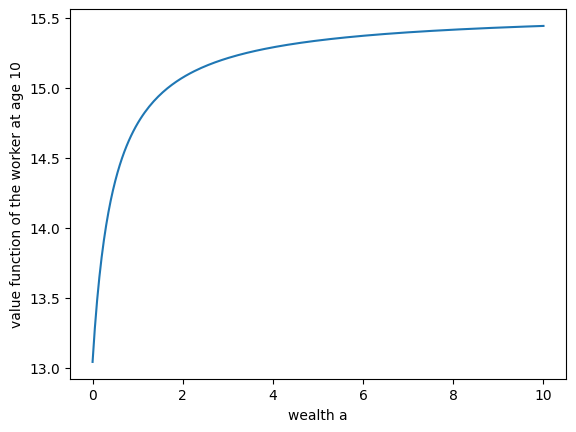

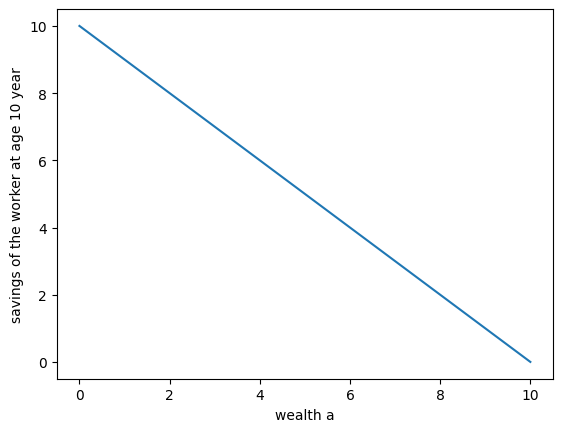

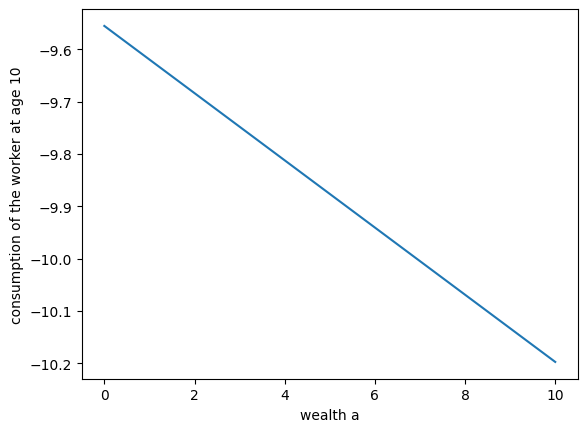

In [127]:
plt.xlabel('wealth a')
plt.ylabel('value function of the worker at age 10')
plt.plot(k_grid,value_array[:,i-1])
plt.show()
            
            
plt.xlabel('wealth a')
plt.ylabel('savings of the worker at age 10 year')
plt.plot(k_grid,k_optimal_array[:,i-1]-k_grid)
plt.show()
            
            
plt.xlabel('wealth a')
plt.ylabel('consumption of the worker at age 10')
plt.plot(k_grid,c_optimal_array[:,i-1])
plt.show()

Solution for aggregate capital stock K: 9.72244305590032
Solution for aggregate labor N: 0.2


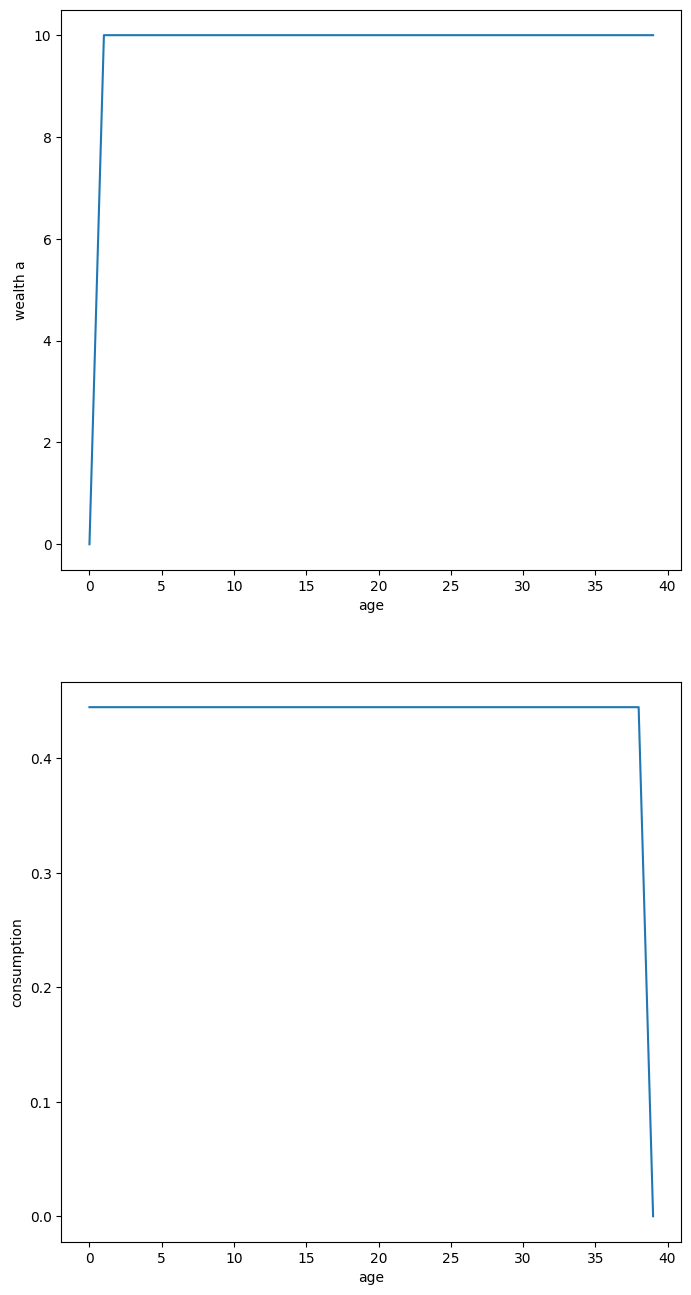

In [128]:
print("Solution for aggregate capital stock K: " + str(K_bar))
print("Solution for aggregate labor N: " + str(L_bar))

fig, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].set_xlabel('age')
axes[0].set_ylabel('wealth a')
axes[0].plot(k_gen)
axes[1].set_xlabel('age')
axes[1].set_ylabel('consumption')
axes[1].plot(c_gen)
plt.show()                


# plt.xlabel('age')
# plt.ylabel('labor')
# plt.plot(ngen)
# plt.show()